In [1]:
import sys
import os
import glob

sys.path.append(os.environ["BUILD_WORKSPACE_DIRECTORY"])
import json
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch
import cv2
import copy
import pandas as pd

DATA_DIR = "/home/gabriel/data/alphapose/synthetic"
datasets = [dataset for dataset in os.listdir(DATA_DIR)]
MODEL_DIR = "/home/gabriel/models/alphapose"
models = glob.glob(os.path.join(MODEL_DIR, "*/*.pth"))
INFERENCE_DIR = "/home/gabriel/inference/alphapose"
AP_INFERENCE_DIR = os.path.join(INFERENCE_DIR, "alphapose_inference")
VOXEL_INFERENCE_DIR = os.path.join(INFERENCE_DIR, "voxel_inference")
ANALYSIS_DIR = "/home/gabriel/analysis/voxel_ap_parity"

In [2]:
def create_alpha_pose_detection_file_schema(
    dataset_path, annotation_file="annotations.json", image_folder="rgb"
):
    # https://github.com/MVIG-SJTU/AlphaPose/blob/master/alphapose/utils/file_detector.py
    alpha_pose_detection_data = []
    save_file = os.path.join(dataset_path, "alpha_pose_detection.json")
    with open(os.path.join(dataset_path, annotation_file), "r") as f:
        annotations = json.load(f)
    images = {
        value["id"]: os.path.join(
            dataset_path, os.path.join(image_folder, value["file_name"])
        )
        for value in annotations["images"]
    }
    all_annotations = annotations["annotations"]
    for annotation in all_annotations:
        if annotation["category_id"] != 0:
            continue
        image_idx = annotation["image_id"]
        image_id = images[image_idx]
        bbox = annotation["bbox"]
        idx = annotation["id"]
        alpha_pose_detection_data.append(
            {
                "image_idx": image_idx,
                "image_id": image_id,
                "bbox": bbox,
                "score": 1,
                "idx": idx,
            }
        )
    with open(save_file, "w") as f:
        json.dump(alpha_pose_detection_data, f)

    return save_file

In [3]:
# # Create alpha pose schema for inference
# for dataset in datasets:
#     data_dir = os.path.join(DATA_DIR, dataset)
#     create_alpha_pose_detection_file_schema(data_dir)

In [87]:
# # Validate BBOX consistency between both GT and AlphaPose
test_dataset = datasets[0]
annotation_path = os.path.join(DATA_DIR, test_dataset)
ap_inference_path = os.path.join(AP_INFERENCE_DIR, test_dataset)
with open(os.path.join(annotation_path, "annotations.json"), "r") as f:
    annotations = json.load(f)["annotations"]
    annotations = {
        ann["id"]: ann for ann in annotations if ann["category_id"] == 0
    }
with open(os.path.join(ap_inference_path, "alphapose-results.json"), "r") as f:
    ap_inference = json.load(f)
    ap_inference_valid = {
        ann["idx"]: ann for ann in ap_inference if type(ann["idx"]) == int
    }
    ap_inference_invalid = [
        ann for ann in ap_inference if type(ann["idx"]) != int
    ]

for idx in ap_inference_valid.keys():
    gt = annotations[idx]
    gt_bbox = gt["bbox"]
    ap = ap_inference_valid[idx]
    ap_bbox = ap["box"]
    if gt_bbox != ap_bbox:
        ap_inference_invalid.append(ap)

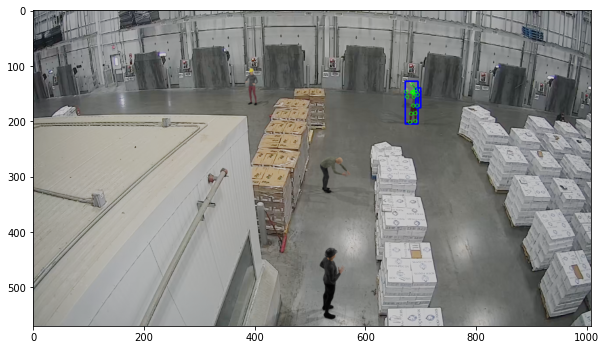

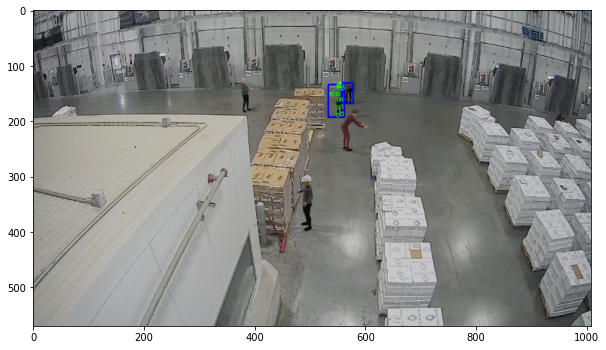

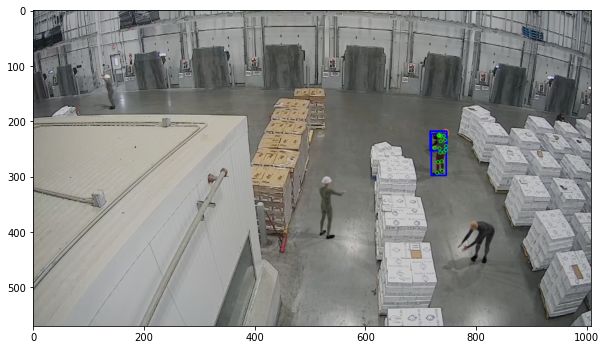

In [88]:
# Debug Instances where 2 GT actors generate same KP result
IMG_PATH = os.path.join(DATA_DIR, os.path.join(test_dataset, "rgb"))
for res in ap_inference_invalid:
    idxs = res["idx"]
    img_name = res["image_id"]
    sample_image = Image.open(os.path.join(IMG_PATH, img_name))
    img_array = np.ascontiguousarray(sample_image)[..., :3].astype(np.uint8)
    raw_kp = res["keypoints"]
    kp = []
    for i in range(0, len(raw_kp), 3):
        kp.append(cv2.KeyPoint(raw_kp[i], raw_kp[i + 1], 1))
    for idx in idxs:
        gt = annotations[idx]
        x1, y1, w, h = gt["bbox"]
        x1 = int(x1)
        y1 = int(y1)
        x2 = int(x1 + w)
        y2 = int(y1 + h)
        img_array = cv2.rectangle(
            img_array, (x1, y1), (x2, y2), (0, 0, 255), 2
        )
    img_array = cv2.drawKeypoints(img_array, kp, 0, (0, 255, 0))
    plt.figure(figsize=(10, 20))
    plt.imshow(img_array)

In [4]:
from core.perception.pose.api import FastPose, PoseModel


class PoseModelSyn(PoseModel):
    def __call__(self, frame, annotation):
        box = [
            annotation["bbox"][0],
            annotation["bbox"][1],
            annotation["bbox"][0] + annotation["bbox"][2],
            annotation["bbox"][1] + annotation["bbox"][3],
        ]
        boxes = []
        boxes.append(box)
        boxes = torch.from_numpy(np.asarray(boxes))
        scores = []
        scores.append(1)
        scores = torch.from_numpy(np.asarray(scores))
        results = (
            self._process(frame, boxes, scores) if boxes is not None else []
        )
        pose = None
        for result in results:
            pose = self._get_pose_from_result(result)

        return pose

In [5]:
keypoints_labels = [
    "nose",
    "left_eye",
    "right_eye",
    "left_ear",
    "right_ear",
    "left_shoulder",
    "right_shoulder",
    "left_elbow",
    "right_elbow",
    "left_wrist",
    "right_wrist",
    "left_hip",
    "right_hip",
    "left_knee",
    "right_knee",
    "left_ankle",
    "right_ankle",
]

In [129]:
prod_model_path = "/home/gabriel/models/alphapose/artifacts_03_21_2023_pose_0630_jit_update/fast_res50_256x192.pt"
pose_model = PoseModelSyn(prod_model_path)
for i in range(len(datasets)):
    dataset = datasets[i]
    gt_label_path = os.path.join(
        DATA_DIR, os.path.join(dataset, "annotations.json")
    )
    print(f"Loading {gt_label_path}")
    images_path = os.path.join(DATA_DIR, os.path.join(dataset, "rgb"))
    save_dir = os.path.join(VOXEL_INFERENCE_DIR, dataset)
    print(f"Saving file at {save_dir}")
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    save_path = os.path.join(save_dir, "voxel-results.json")
    with open(gt_label_path) as f:
        gt_labels = json.load(f)
    img_dict = {}
    for img in gt_labels["images"]:
        img_dict[img["id"]] = img["file_name"]
    annotations = gt_labels["annotations"]
    annotations_new = []
    for anno in annotations:
        keypoints_model = []
        img_name = img_dict[anno["image_id"]]
        sample_image = copy.deepcopy(
            Image.open(os.path.join(images_path, img_name))
        )
        if anno["category_id"] == 0:
            img_array = np.asarray(sample_image)[..., :3]
            pose = pose_model(img_array, anno)
            if pose is not None:
                model_output = pose.to_dict()
                for keyp in keypoints:
                    keypoints_model.append(model_output[keyp]["x"])
                    keypoints_model.append(model_output[keyp]["y"])
                    keypoints_model.append(model_output[keyp]["confidence"])
                anno["keypoints"] = keypoints_model
                annotations_new.append(anno)
            else:
                anno["keypoints"] = []
                annotations_new.append(anno)
    with open(save_path, "w") as f:
        json.dump(annotations_new, f)

Loading /home/gabriel/data/alphapose/synthetic/_americold-savannah-bloomingdale-0004/annotations.json
Saving file at /home/gabriel/inference/alphapose/voxel_inference/_americold-savannah-bloomingdale-0004
Loading /home/gabriel/data/alphapose/synthetic/_uscold-laredo-dock01/annotations.json
Saving file at /home/gabriel/inference/alphapose/voxel_inference/_uscold-laredo-dock01
Loading /home/gabriel/data/alphapose/synthetic/_americold-savannah-pooler-0007/annotations.json
Saving file at /home/gabriel/inference/alphapose/voxel_inference/_americold-savannah-pooler-0007
Loading /home/gabriel/data/alphapose/synthetic/_americold-savannah-bloomingdale-0006/annotations.json
Saving file at /home/gabriel/inference/alphapose/voxel_inference/_americold-savannah-bloomingdale-0006
Loading /home/gabriel/data/alphapose/synthetic/_americold-savannah-bloomingdale-0002/annotations.json
Saving file at /home/gabriel/inference/alphapose/voxel_inference/_americold-savannah-bloomingdale-0002
Loading /home/gabri

In [6]:
def oks(pred_kp, gt_kp, visibility):
    KAPPA = np.array([1] * len(gt_kp))
    SCALE = 1.0
    distances = np.linalg.norm(pred_kp - gt_kp, axis=-1)
    exp_vector = np.exp(-(distances**2) / (2 * (SCALE**2) * (KAPPA**2)))
    numerator = np.dot(exp_vector, visibility.astype(bool).astype(int))
    denominator = np.sum(visibility.astype(bool).astype(int))
    return numerator / denominator

In [22]:
def run_oks_for_dataset(
    dataset_name,
    gt_dir=DATA_DIR,
    voxel_inf_dir=VOXEL_INFERENCE_DIR,
    ap_inf_dir=AP_INFERENCE_DIR,
    save_dir=ANALYSIS_DIR,
):
    gt_path = os.path.join(
        DATA_DIR, os.path.join(dataset_name, "annotations.json")
    )
    voxel_inf_path = os.path.join(
        VOXEL_INFERENCE_DIR, os.path.join(dataset, "voxel-results.json")
    )
    ap_inf_path = os.path.join(
        AP_INFERENCE_DIR, os.path.join(dataset, "alphapose-results.json")
    )
    with open(gt_path, "r") as f:
        gt_data = json.load(f)
        gt_map = {d["id"]: d for d in gt_data["annotations"]}
        image_map = {d["id"]: d for d in gt_data["images"]}
    with open(ap_inf_path, "r") as f:
        ap_inf_data = json.load(f)
        ap_inf_map = {
            d["idx"]: d for d in ap_inf_data if type(d["idx"]) == int
        }
    #         ap_inf_nms = [d for d in ap_inf_data if type(d["idx"]) == list]
    with open(voxel_inf_path, "r") as f:
        voxel_inf_data = json.load(f)
        voxel_inf_map = {d["id"]: d for d in voxel_inf_data}

    track_id_list = []
    img_name_list = []
    oks_voxel_list = []
    oks_ap_list = []
    oks_voxel_ap_list = []
    bbox_x1_list = []
    bbox_y1_list = []
    bbox_w_list = []
    bbox_h_list = []
    for track_id in gt_map.keys():
        gt_data = gt_map[track_id]
        if gt_data["category_id"] != 0:
            continue
        gt_box = gt_data["bbox"]
        gt_kp_data = np.array(gt_data["keypoints"]).reshape(-1, 3)
        gt_kp = gt_kp_data[:, 0:2]
        vis = gt_kp_data[:, 2]
        voxel_kp = voxel_inf_map.get(track_id, {}).get("keypoints", None)
        voxel_oks = None
        if voxel_kp:
            voxel_kp = np.array(voxel_kp).reshape(-1, 3)[:, 0:2]
            voxel_oks = oks(voxel_kp, gt_kp, vis)
        ap_kp = ap_inf_map.get(track_id, {}).get("keypoints", None)
        ap_oks = None
        if ap_kp:
            ap_kp = np.array(ap_kp).reshape(-1, 3)[:, 0:2]
            ap_oks = oks(ap_kp, gt_kp, vis)
        voxel_ap_oks = None
        if voxel_kp is not None and ap_kp is not None:
            voxel_ap_oks = oks(voxel_kp, ap_kp, vis)
        track_id_list.append(track_id)
        img_name_list.append(image_map[gt_data["image_id"]]["file_name"])
        oks_voxel_list.append(voxel_oks)
        oks_ap_list.append(ap_oks)
        oks_voxel_ap_list.append(voxel_ap_oks)
        bbox_x1_list.append(gt_box[0])
        bbox_y1_list.append(gt_box[1])
        bbox_w_list.append(gt_box[2])
        bbox_h_list.append(gt_box[3])

    df = pd.DataFrame(
        {
            "track_id": track_id_list,
            "image": img_name_list,
            "voxel_oks": oks_voxel_list,
            "ap_oks": oks_ap_list,
            "voxel_ap_oks": oks_voxel_ap_list,
            "bbox_x1": bbox_x1_list,
            "bbox_y1": bbox_y1_list,
            "bbox_w": bbox_w_list,
            "bbox_h": bbox_h_list,
        }
    )
    save_path = os.path.join(save_dir, dataset)
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    df.to_csv(os.path.join(save_path, "oks_analysis.csv"), index=False)

In [23]:
for dataset in datasets:
    print(dataset)
    run_oks_for_dataset(dataset)

_americold-savannah-bloomingdale-0004
_uscold-laredo-dock01
_americold-savannah-pooler-0007
_americold-savannah-bloomingdale-0006
_americold-savannah-bloomingdale-0002
_americold-savannah-pooler-0006
_americold-savannah-pooler-0009
_americold-savannah-pooler-0005
_americold-savannah-bloomingdale-0007
_americold-savannah-pooler-0008
_americold-savannah-pooler-0004
_americold-savannah-bloomingdale-0005


In [106]:
def plot_boxplot_oks(dataset, analysis_dir=ANALYSIS_DIR):
    df = pd.read_csv(
        os.path.join(ANALYSIS_DIR, os.path.join(dataset, "oks_analysis.csv"))
    )
    df = df[["voxel_oks", "ap_oks", "voxel_ap_oks"]]
    voxel_oks = df["voxel_oks"][~df["voxel_oks"].isna()].astype(float)
    ap_oks = df["ap_oks"][~df["ap_oks"].isna()].astype(float)
    voxel_ap_oks = df["voxel_ap_oks"][~df["voxel_ap_oks"].isna()].astype(float)
    data = {
        "voxel_oks": voxel_oks,
        "ap_oks": ap_oks,
        "voxel_ap_oks": voxel_ap_oks,
    }
    fs = 30
    fig, ax = plt.subplots(figsize=(40, 20))
    ax.boxplot(data.values())
    ax.set_xticklabels(data.keys(), fontsize=fs)
    plt.yticks(np.linspace(0, 1, 11), fontsize=fs)
    plt.grid(True)
    plt.ylim([-0.01, 1.01])
    plt.title(dataset, fontsize=fs)
    plt.show()
    print(df.describe().apply(lambda s: s.apply(lambda x: format(x, "g"))))

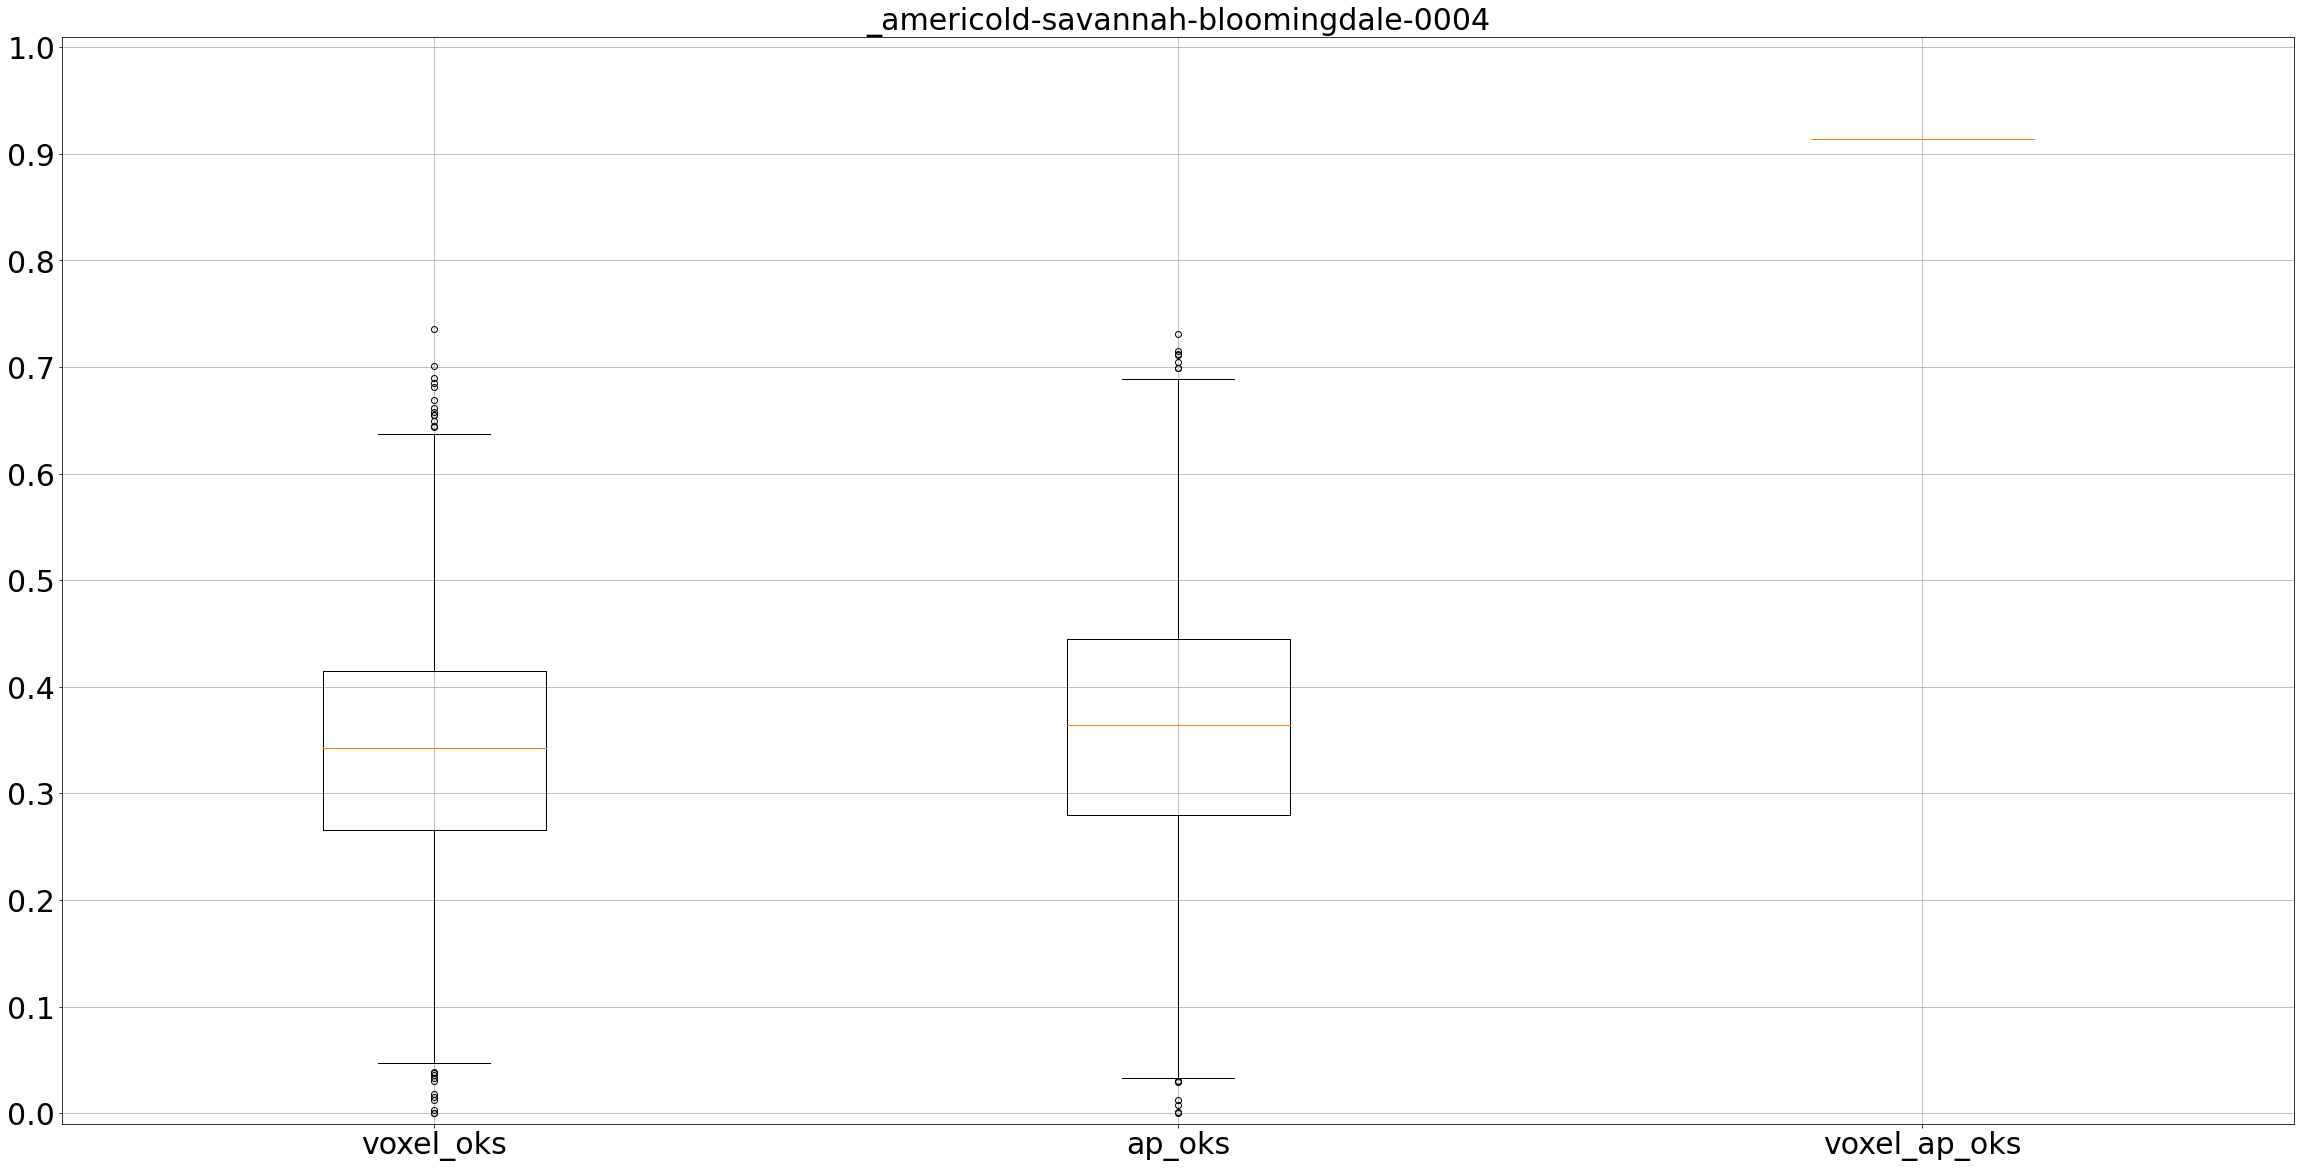

         voxel_oks       ap_oks voxel_ap_oks
count         5000         4994         4994
mean      0.342481     0.363147     0.913935
std       0.107784     0.113966  2.37269e-06
min    4.04035e-05  0.000141023      0.91393
25%       0.265401     0.279799     0.913934
50%       0.342498     0.364425     0.913934
75%       0.415254     0.444413     0.913938
max       0.735843     0.730711     0.913938


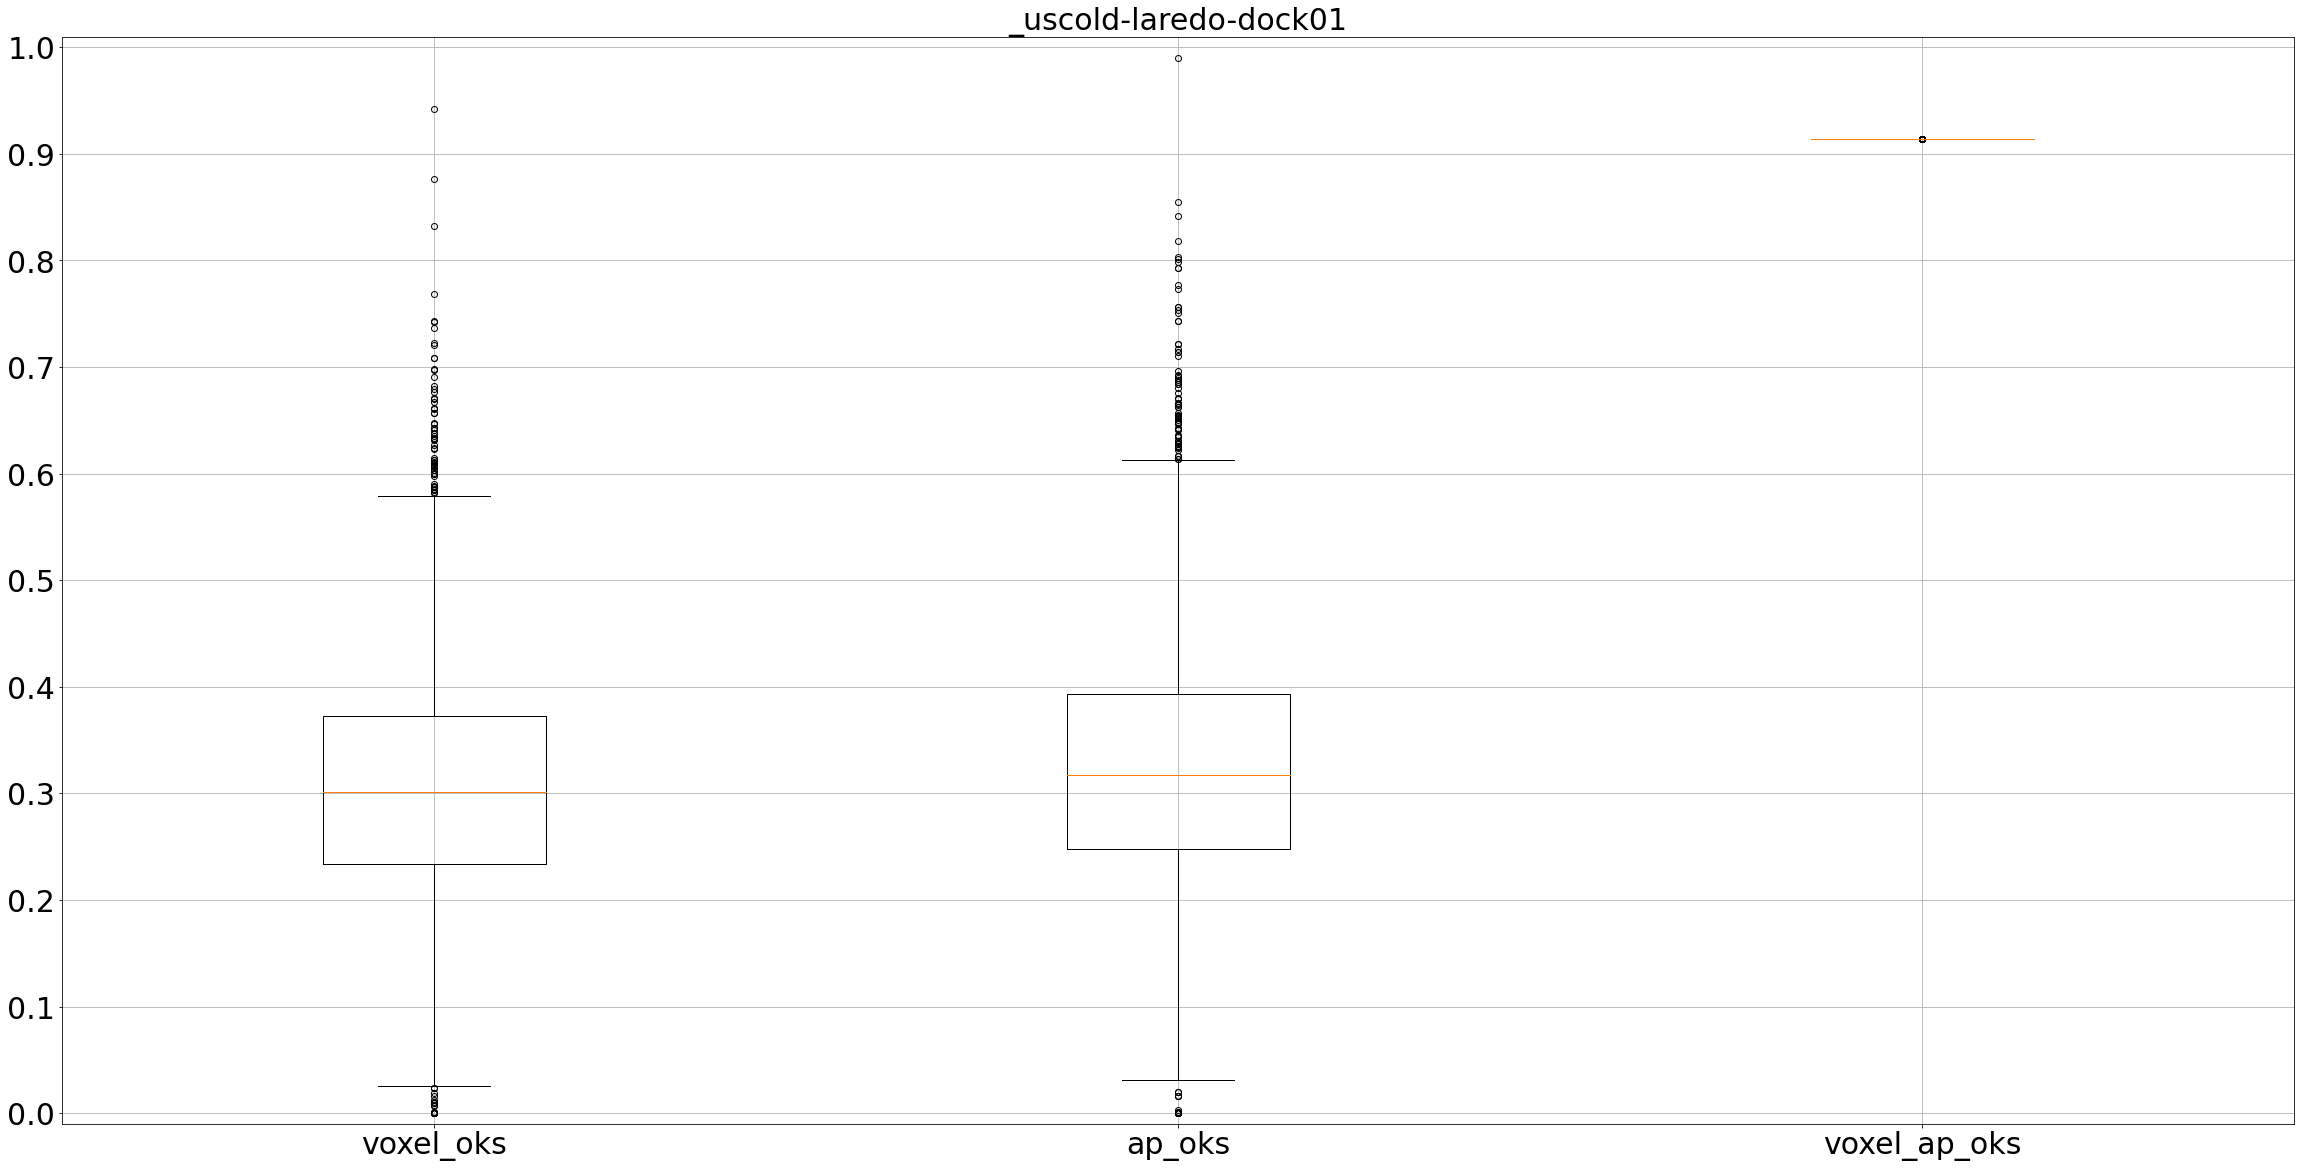

        voxel_oks       ap_oks voxel_ap_oks
count        4990         4980         4980
mean     0.307144     0.324759     0.913934
std      0.107435     0.113496  2.12487e-06
min    1.4483e-48  5.41126e-50      0.91393
25%      0.233722     0.247363     0.913934
50%      0.301365     0.317623     0.913934
75%      0.372989     0.393664     0.913935
max      0.941607     0.989948     0.913938


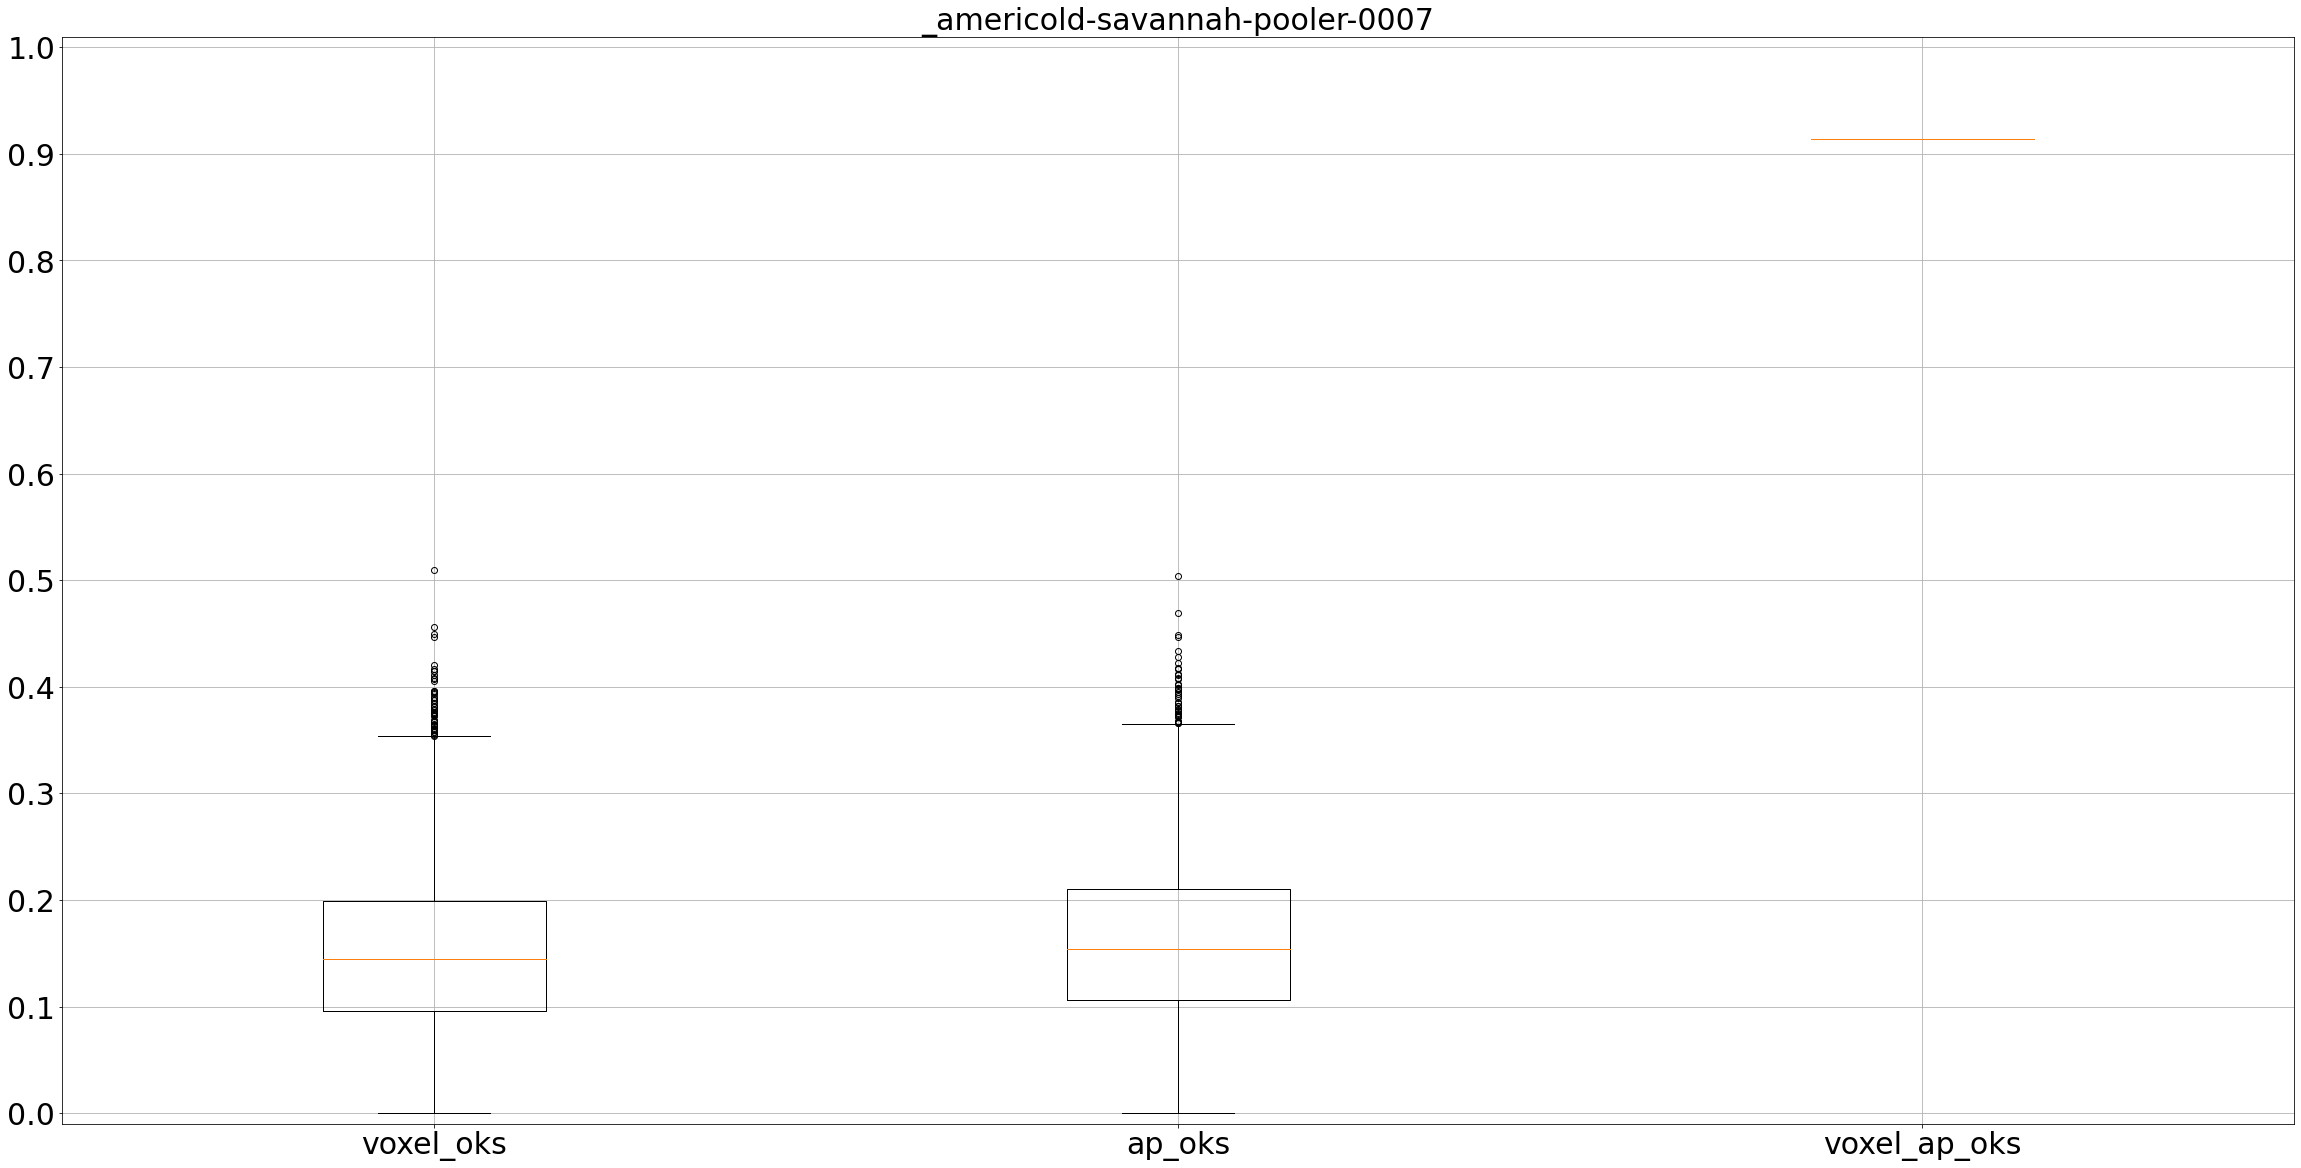

          voxel_oks       ap_oks voxel_ap_oks
count          5000         4850         4850
mean       0.151468     0.161704     0.913936
std       0.0763503    0.0770722  2.30516e-06
min    4.46575e-307  3.71132e-05     0.913931
25%       0.0961614     0.106557     0.913934
50%        0.144885      0.15416     0.913938
75%        0.199189     0.210344     0.913938
max        0.509996      0.50349     0.913938


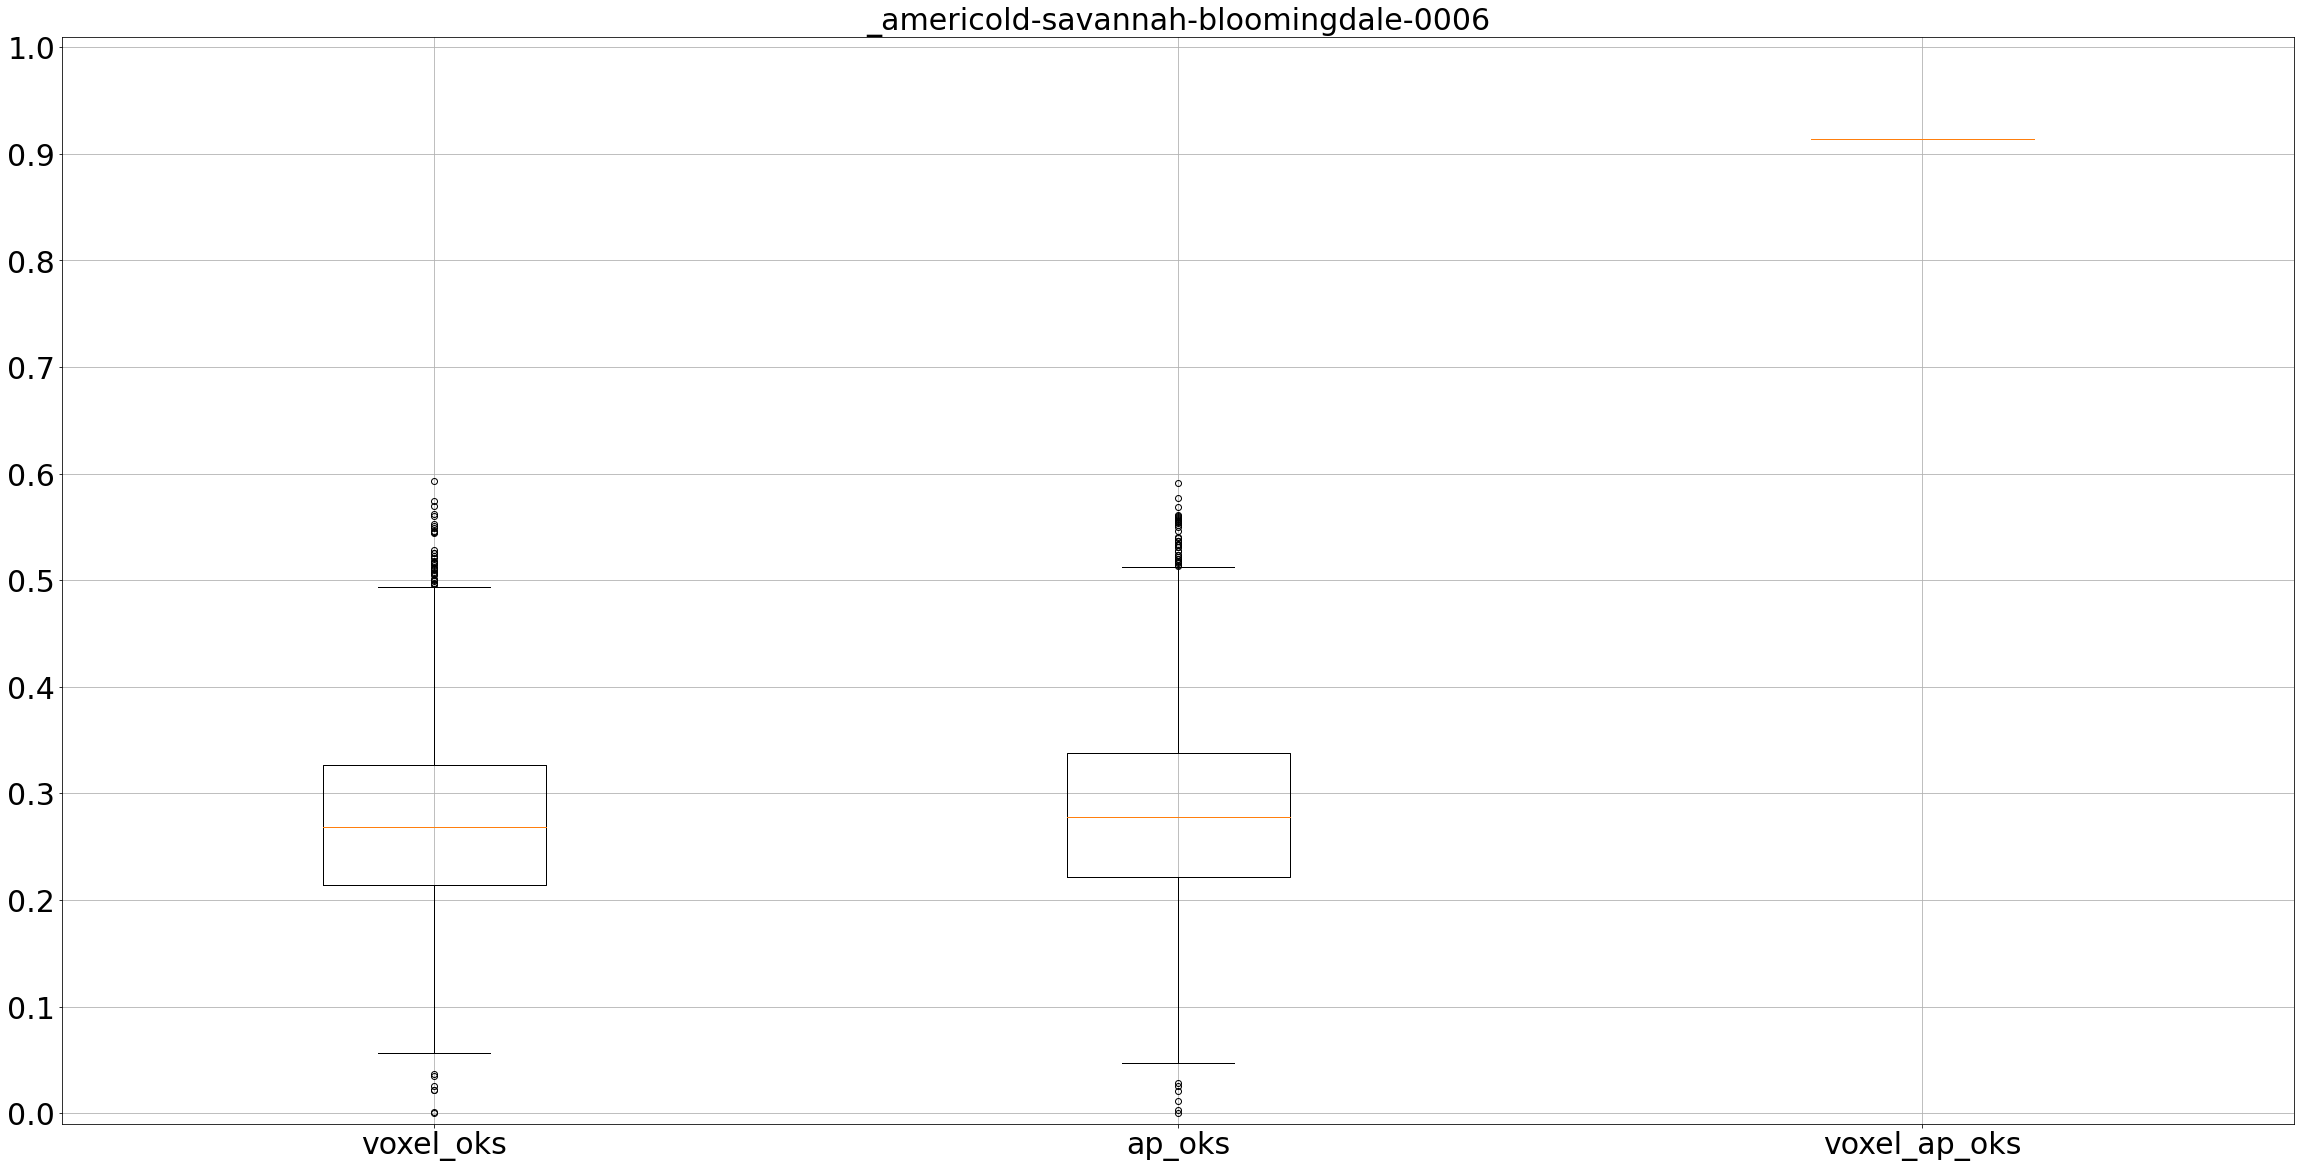

         voxel_oks       ap_oks voxel_ap_oks
count         4995         4993         4993
mean       0.27194     0.281738     0.913936
std      0.0840069    0.0863514  2.09817e-06
min    2.62885e-08  8.35801e-09      0.91393
25%       0.214211      0.22162     0.913934
50%       0.267995      0.27825     0.913938
75%        0.32635     0.338155     0.913938
max       0.593132     0.591122     0.913938


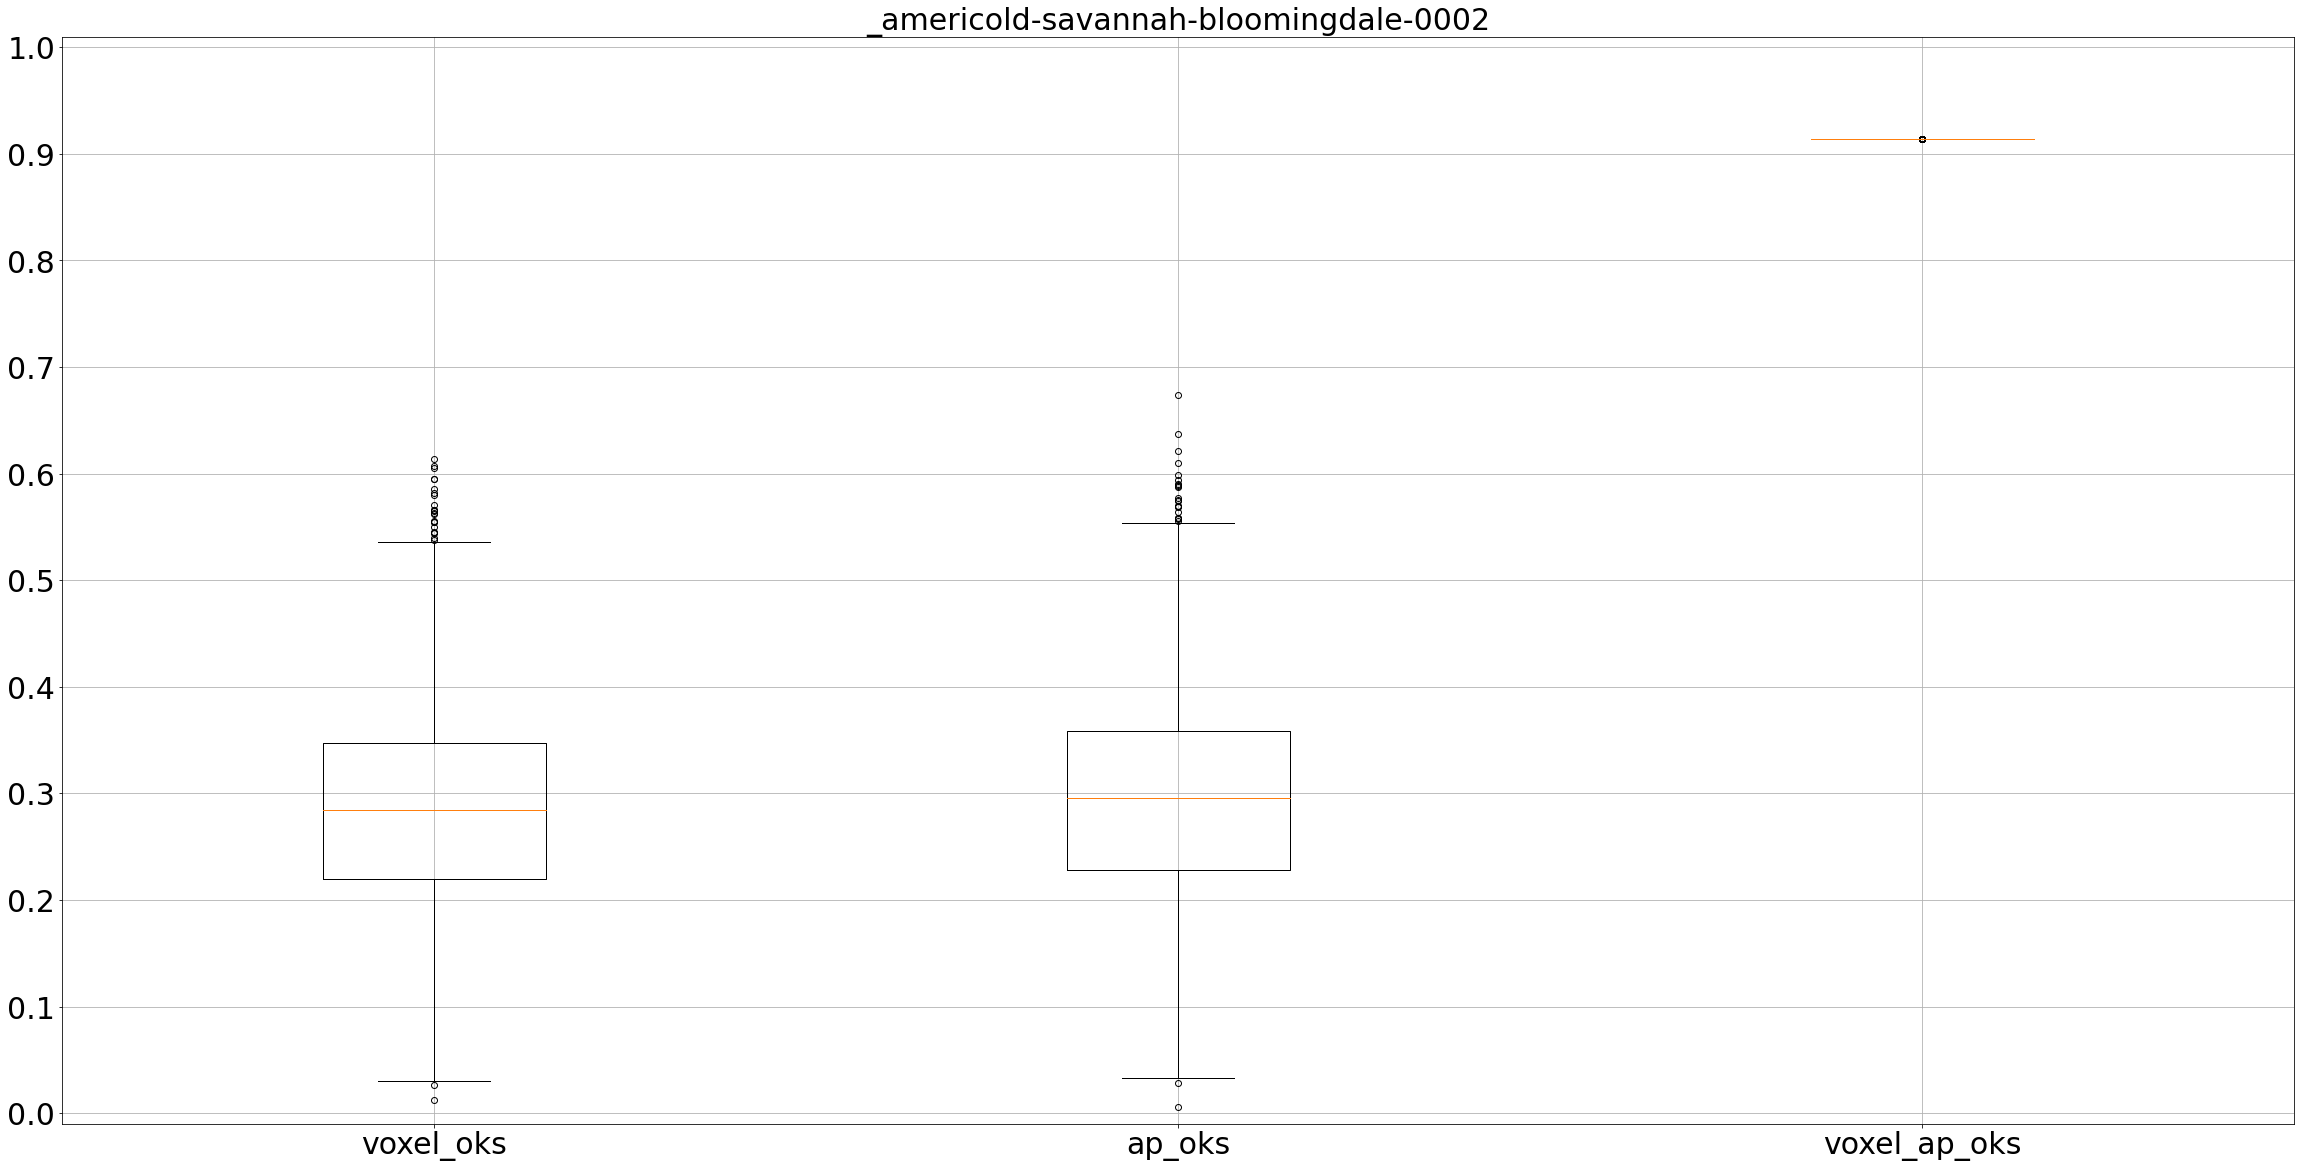

       voxel_oks      ap_oks voxel_ap_oks
count       5000        4998         4998
mean    0.285542    0.295416     0.913934
std    0.0918779   0.0946475  2.31675e-06
min    0.0127103  0.00536644      0.91393
25%     0.220118    0.227825     0.913934
50%     0.284357    0.295793     0.913934
75%     0.346819    0.358659     0.913936
max     0.613442    0.674149     0.913938


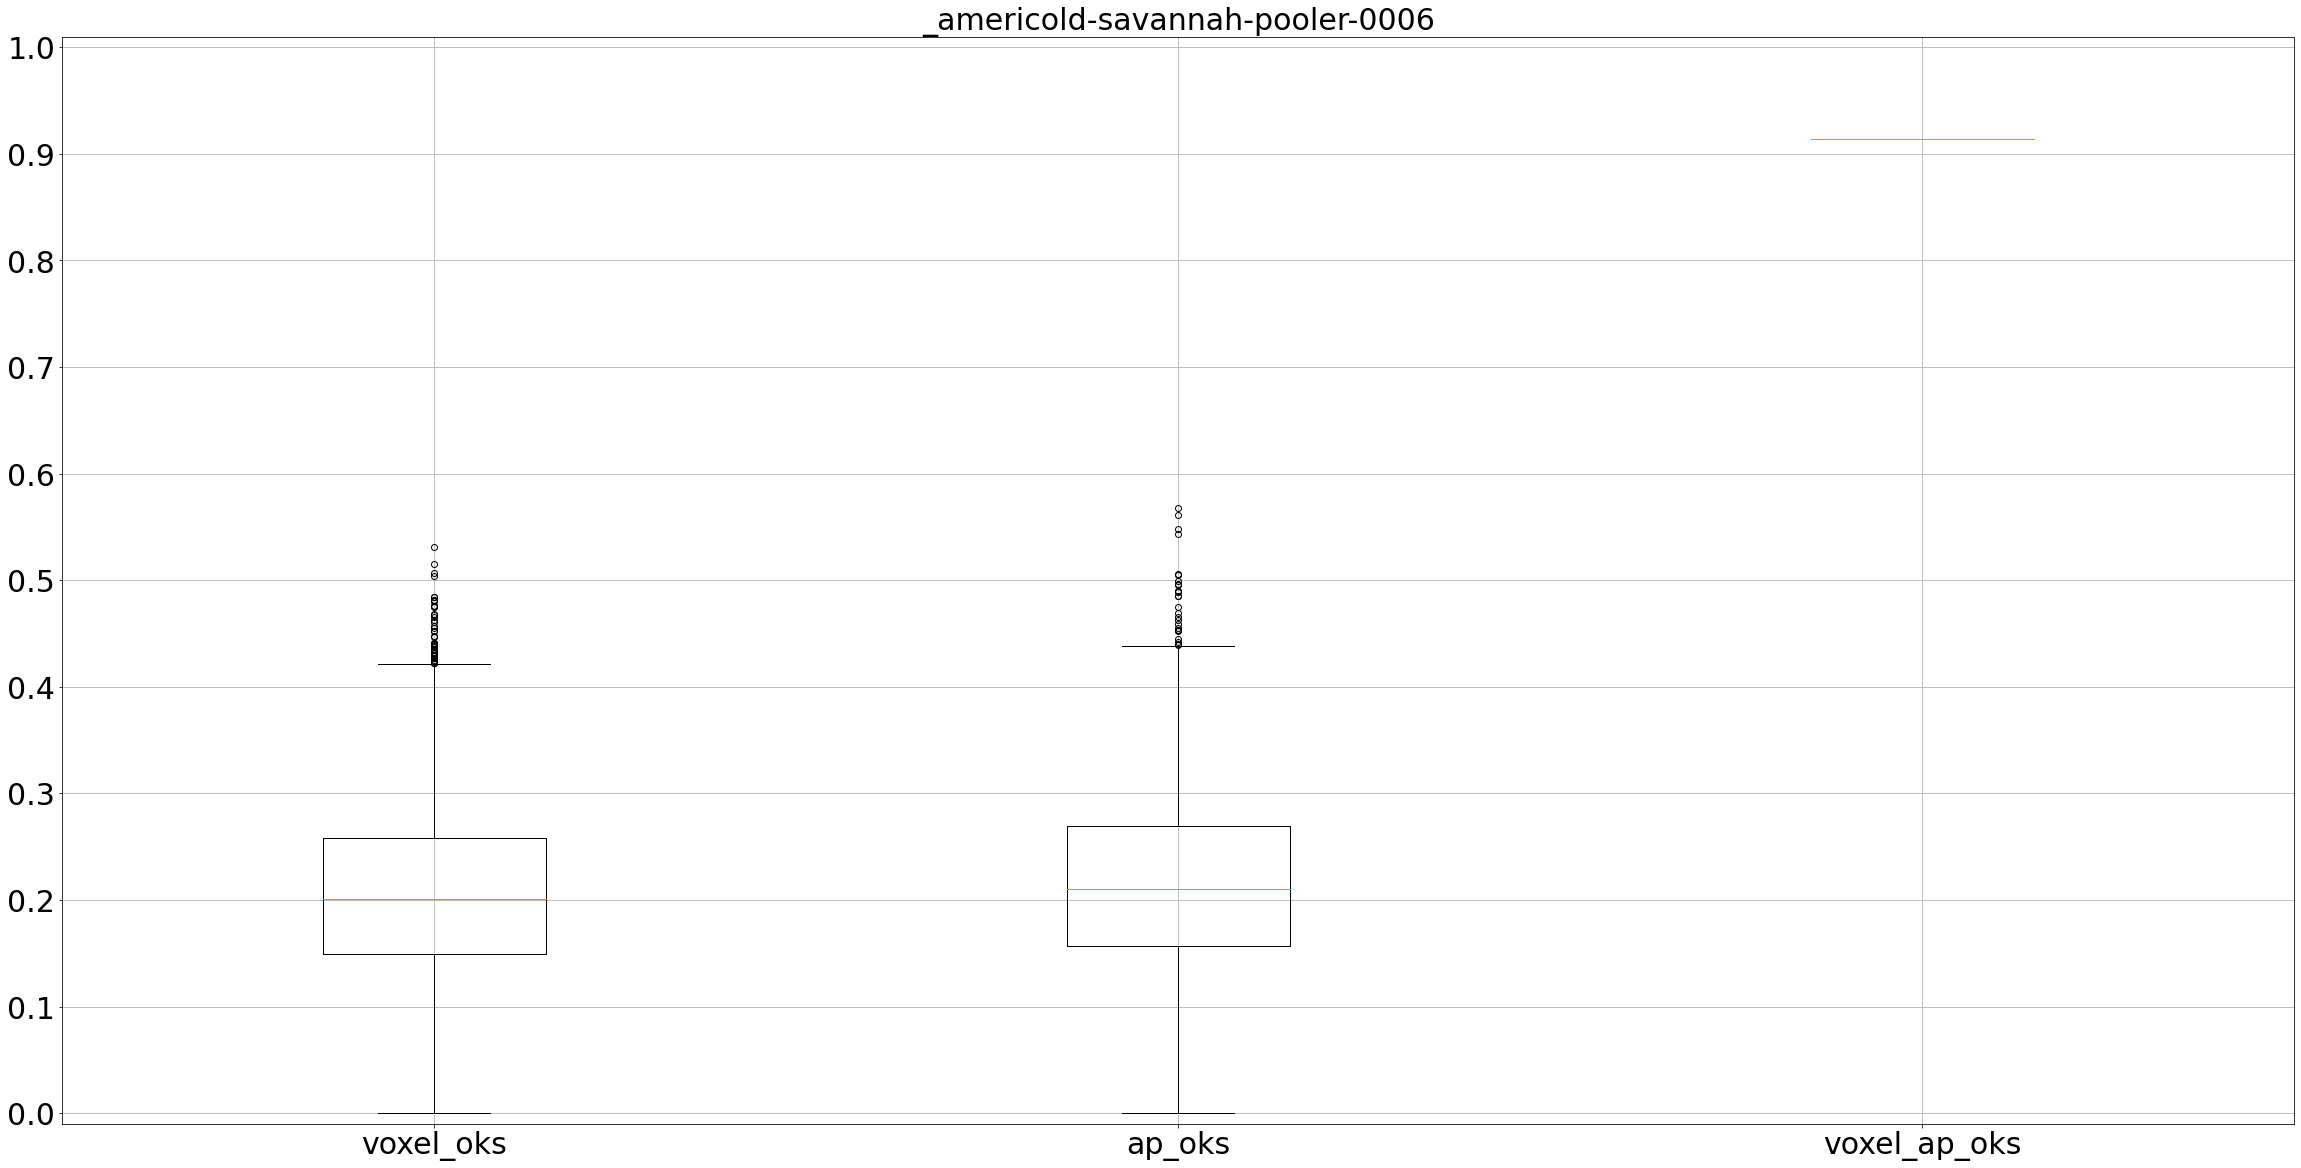

         voxel_oks       ap_oks voxel_ap_oks
count         4918         4918         4918
mean      0.207101       0.2162     0.913936
std      0.0802804    0.0822368  2.13806e-06
min    2.35971e-05  1.79609e-05      0.91393
25%       0.149698     0.156703     0.913934
50%       0.200919     0.210468     0.913938
75%       0.258239     0.269289     0.913938
max       0.531181     0.567434     0.913938


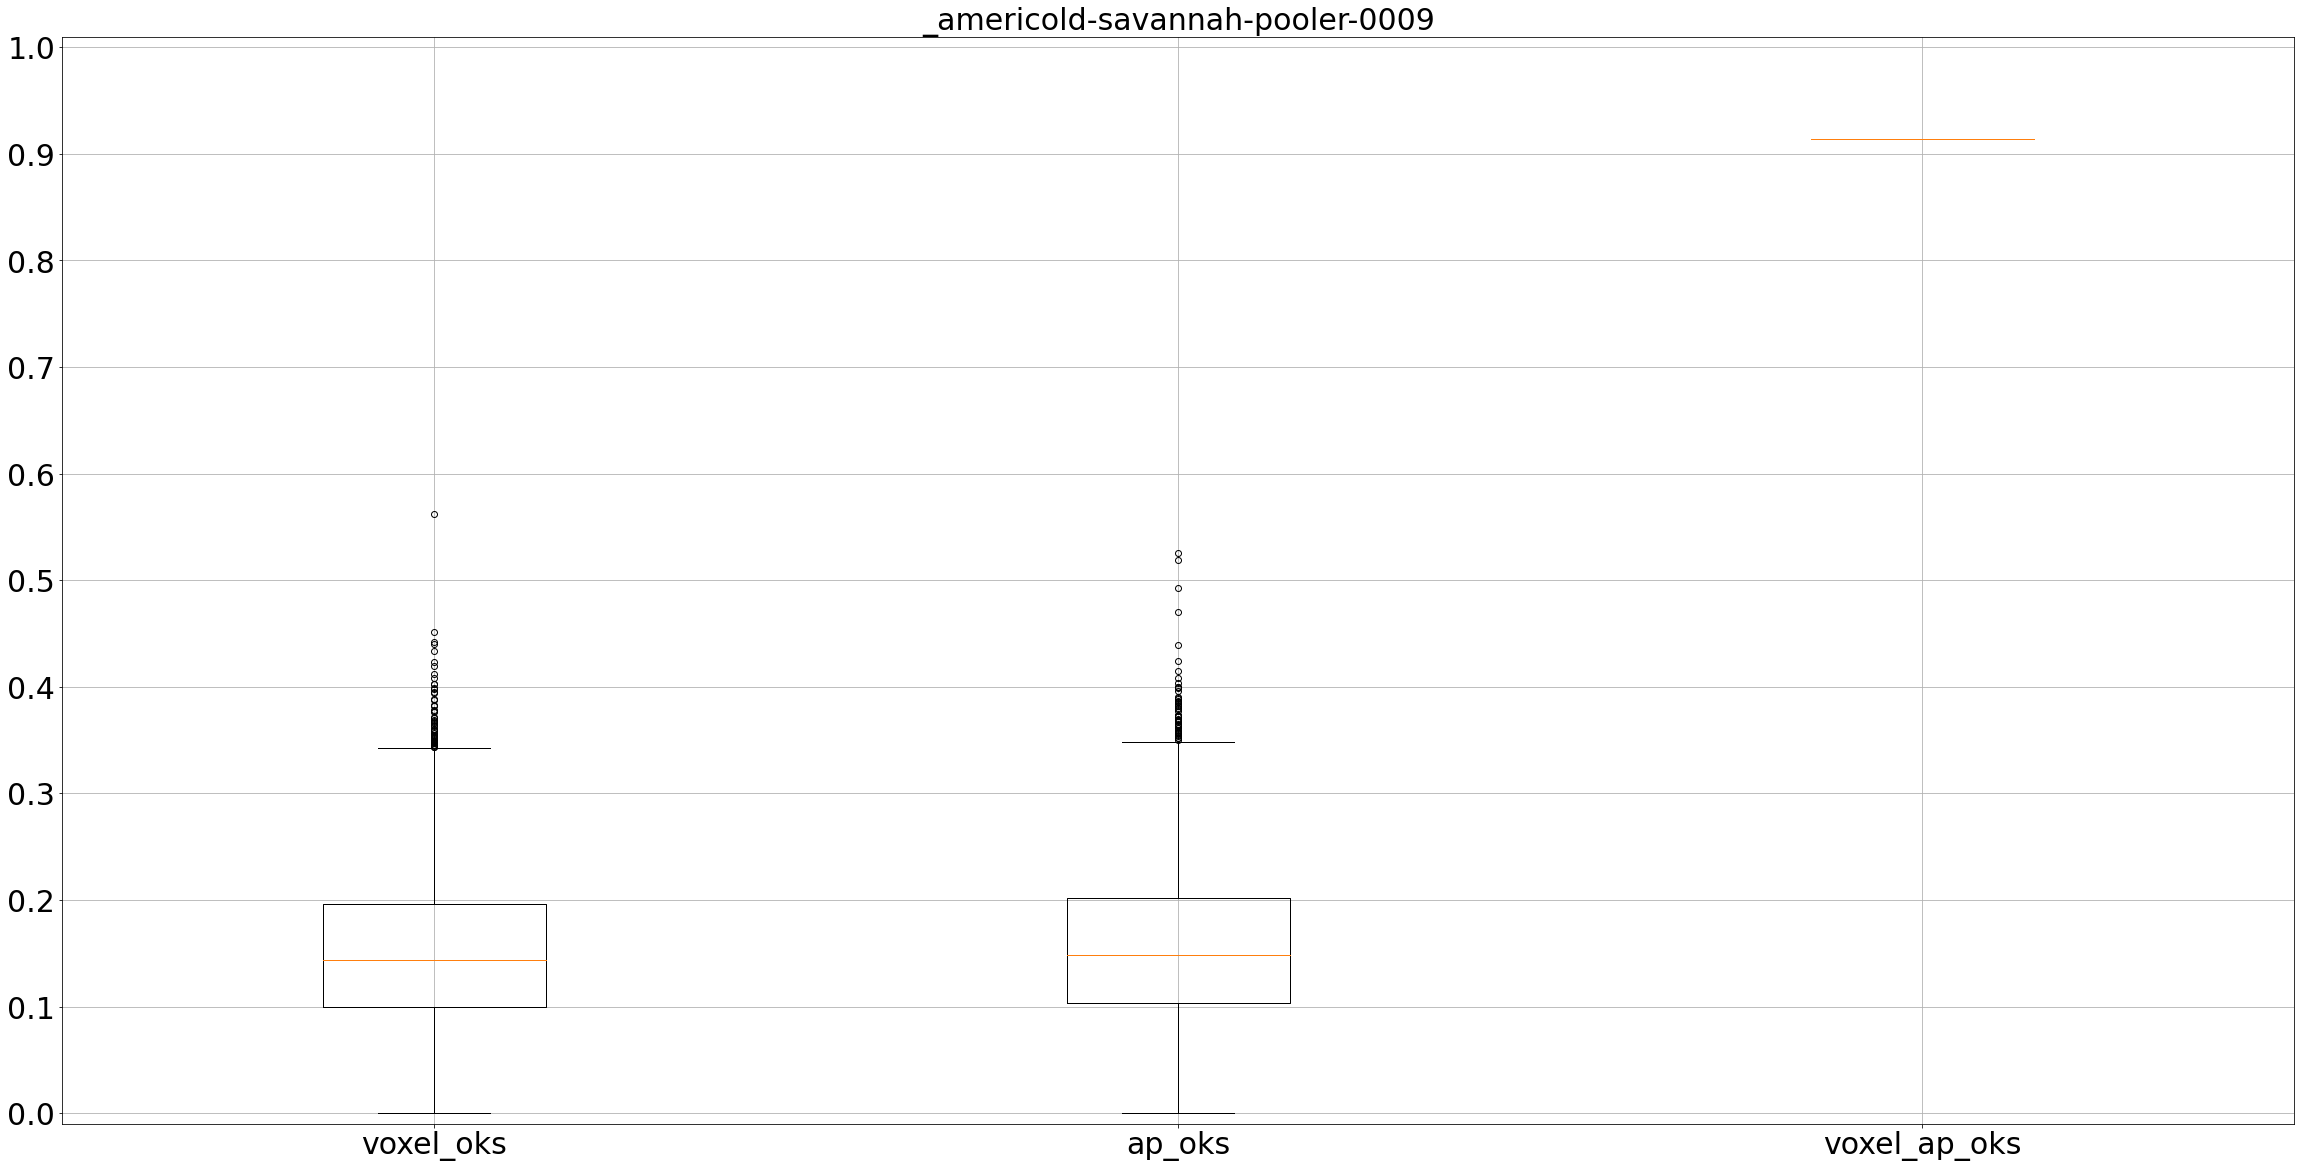

         voxel_oks       ap_oks voxel_ap_oks
count         4998         4958         4958
mean      0.151388     0.155636     0.913937
std      0.0714123    0.0726535  1.57189e-06
min    3.7406e-137  0.000261241     0.913934
25%      0.0994901     0.103273     0.913935
50%       0.143397     0.148363     0.913938
75%       0.196589     0.201449     0.913938
max       0.561758     0.525723     0.913938


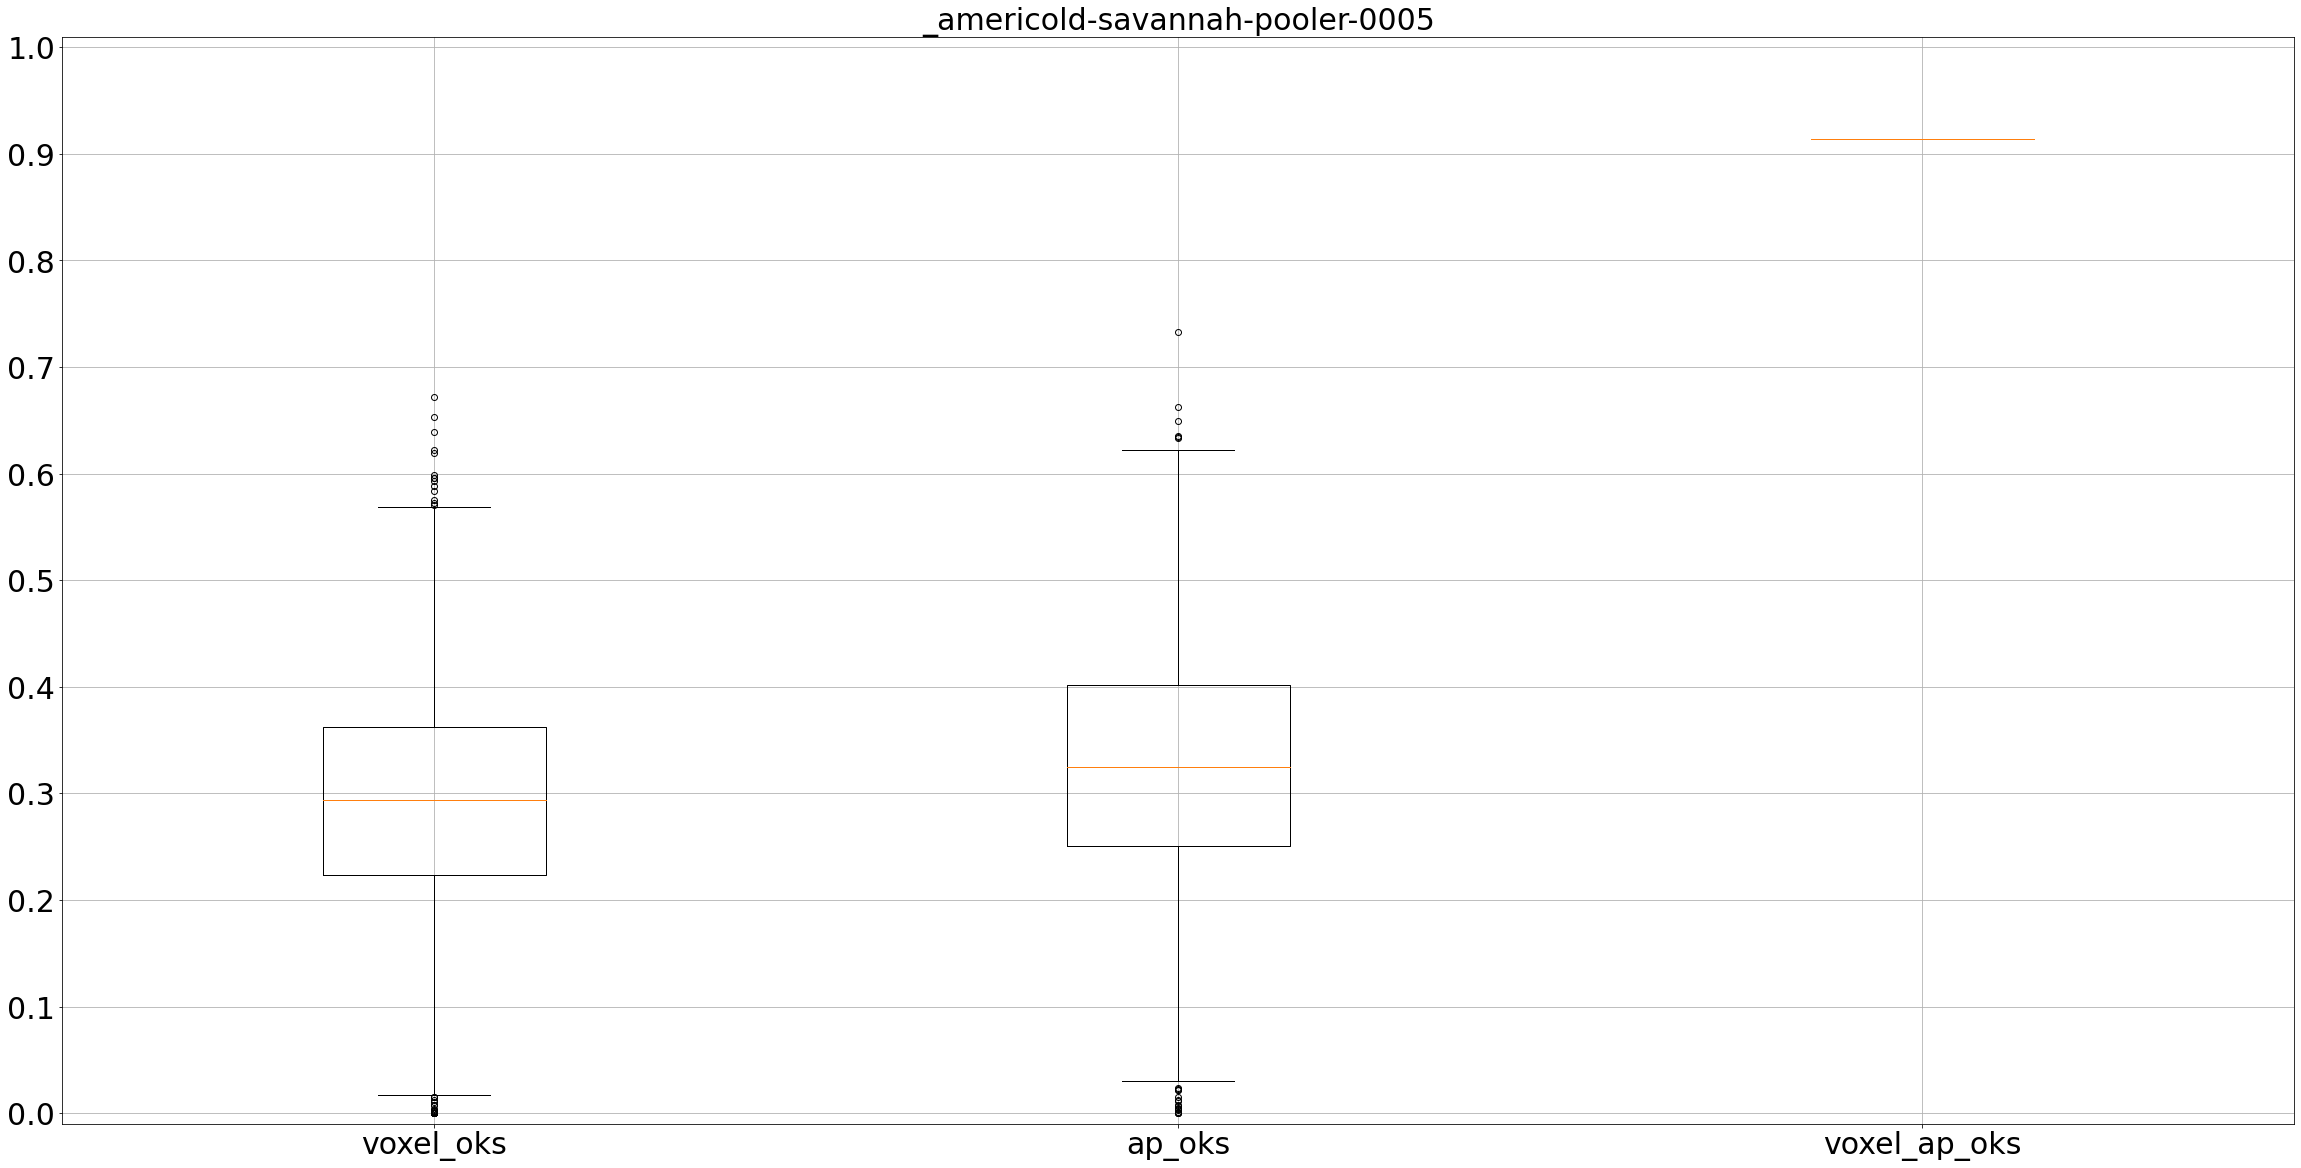

         voxel_oks       ap_oks voxel_ap_oks
count         5000         4940         4940
mean      0.294605      0.32603     0.913936
std       0.101418     0.107954  1.86609e-06
min    1.65062e-46  3.85652e-06     0.913931
25%       0.223675     0.250384     0.913934
50%       0.293862     0.324419     0.913935
75%        0.36207     0.401255     0.913938
max       0.671511     0.732854     0.913938


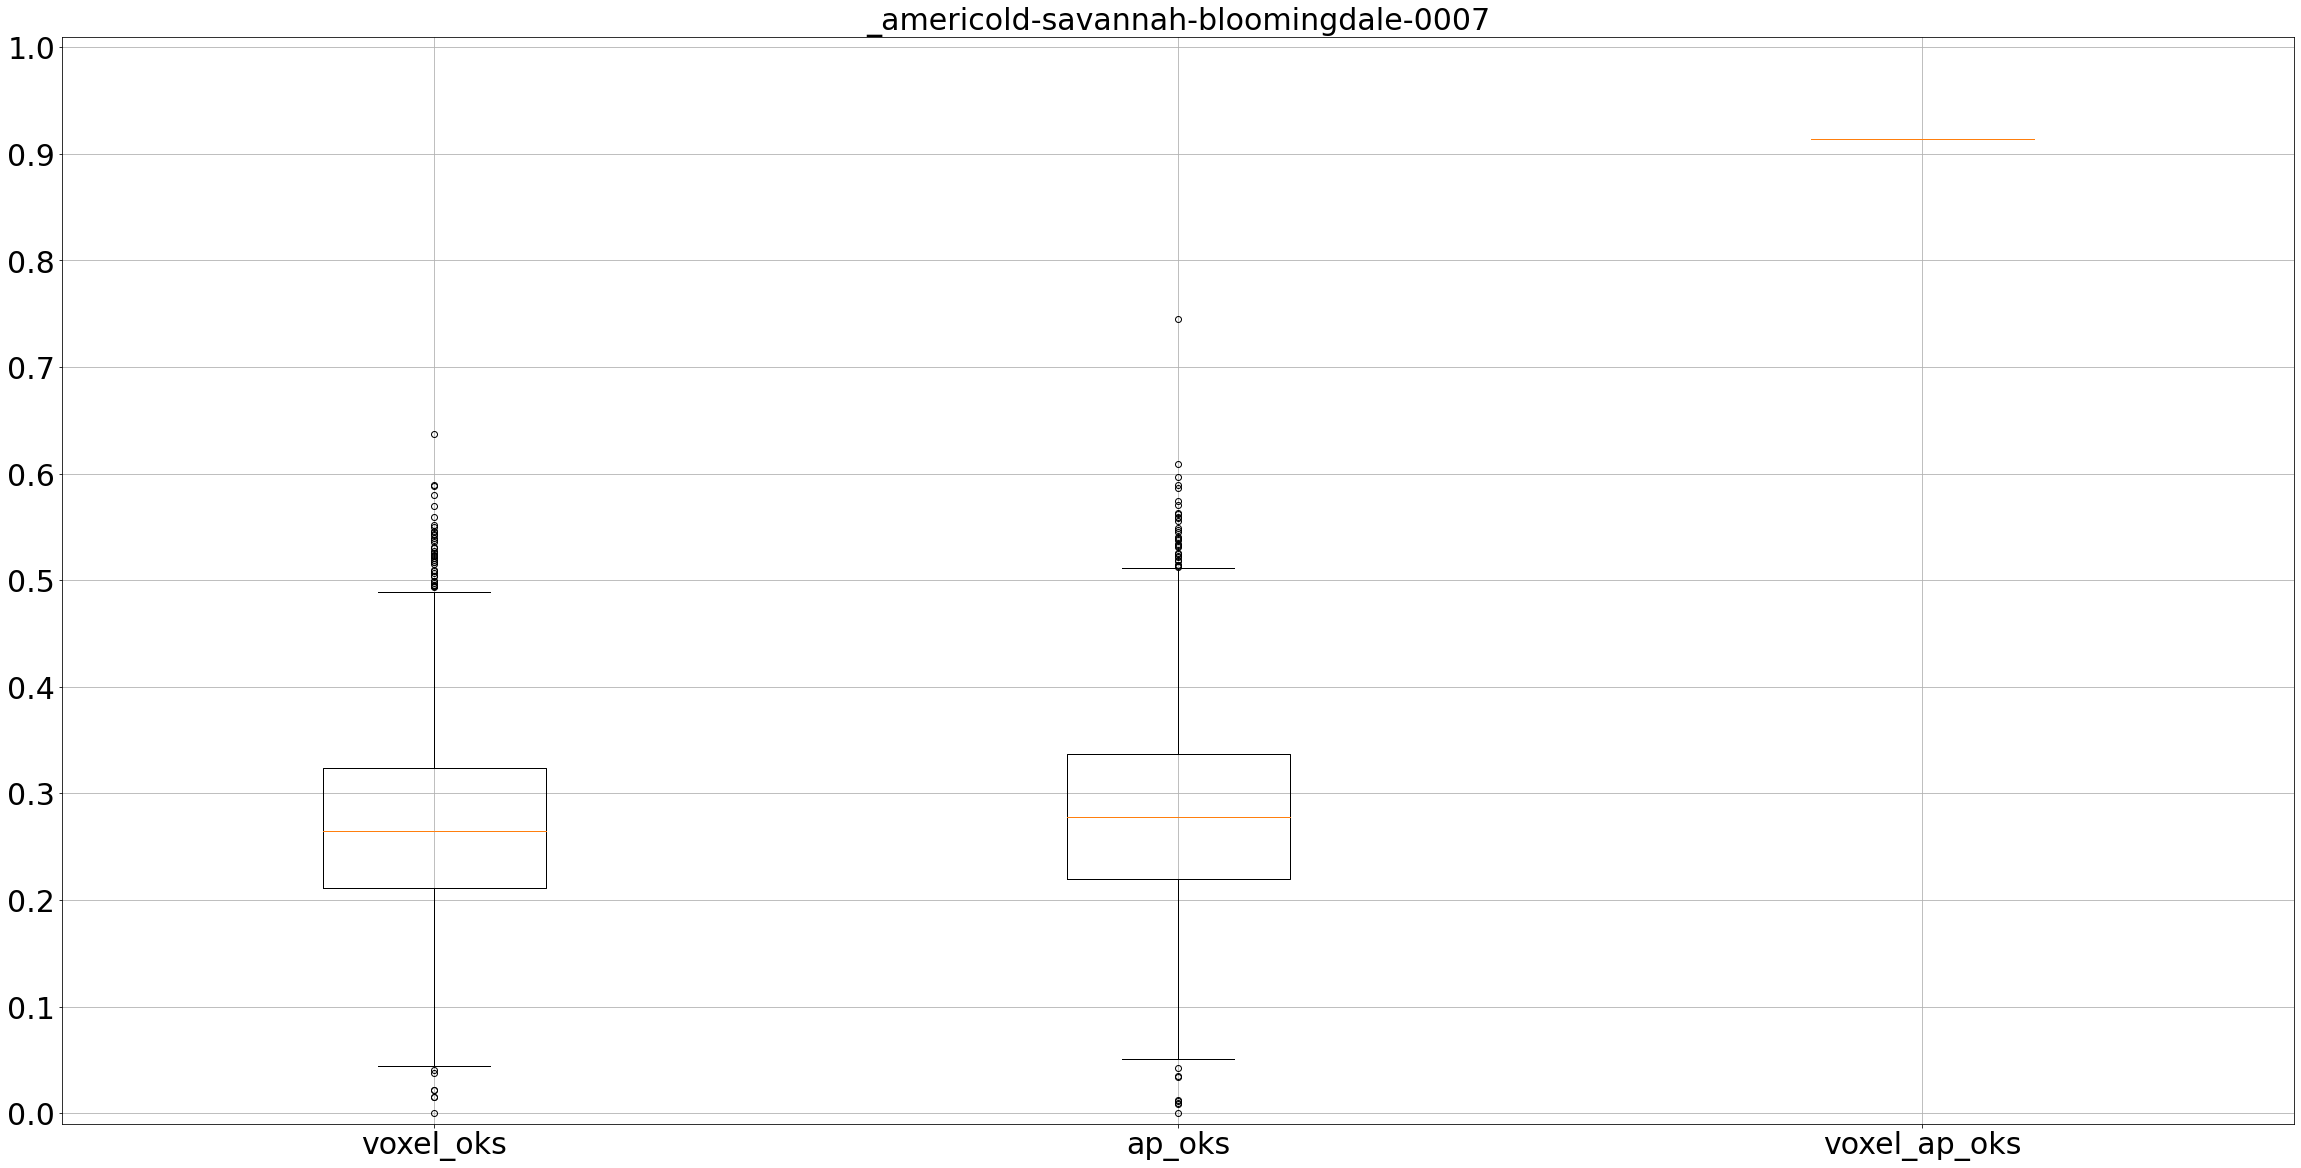

         voxel_oks       ap_oks voxel_ap_oks
count         4999         4999         4999
mean      0.269337      0.28019     0.913937
std      0.0838333     0.085703  1.89933e-06
min    2.02896e-06  6.42827e-07     0.913931
25%        0.21101     0.219813     0.913935
50%       0.264648     0.277543     0.913938
75%       0.323804     0.336766     0.913938
max       0.637305     0.745073     0.913938


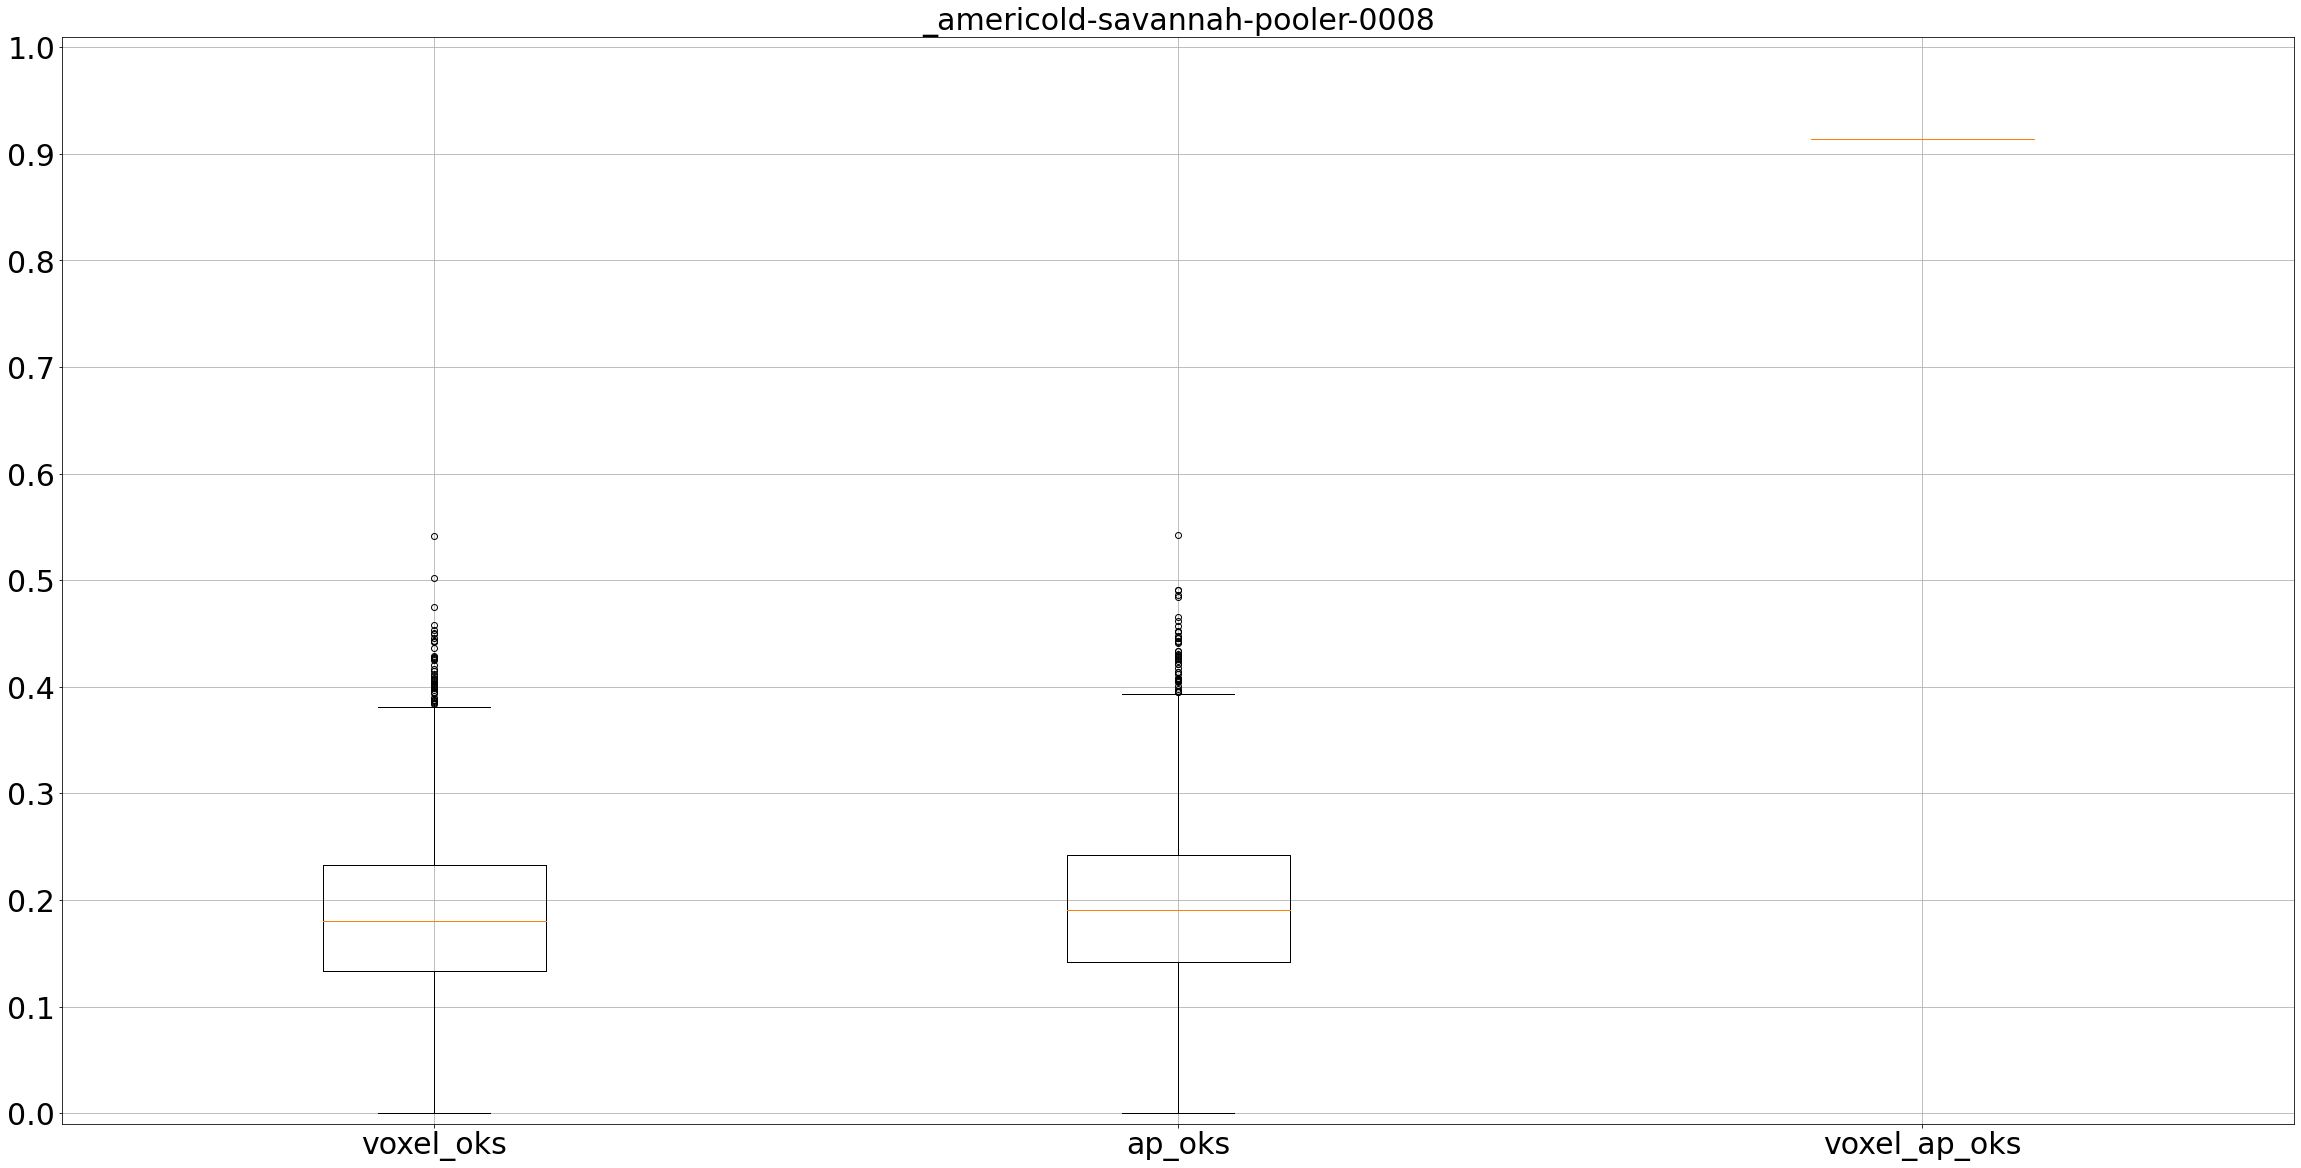

        voxel_oks       ap_oks voxel_ap_oks
count        4998         4986         4986
mean       0.1857     0.194319     0.913937
std     0.0756679    0.0760541  1.86856e-06
min    5.0107e-43  2.17883e-44     0.913931
25%      0.133006     0.141575     0.913935
50%       0.18065     0.190406     0.913938
75%      0.233137     0.242653     0.913938
max      0.541693     0.542735     0.913938


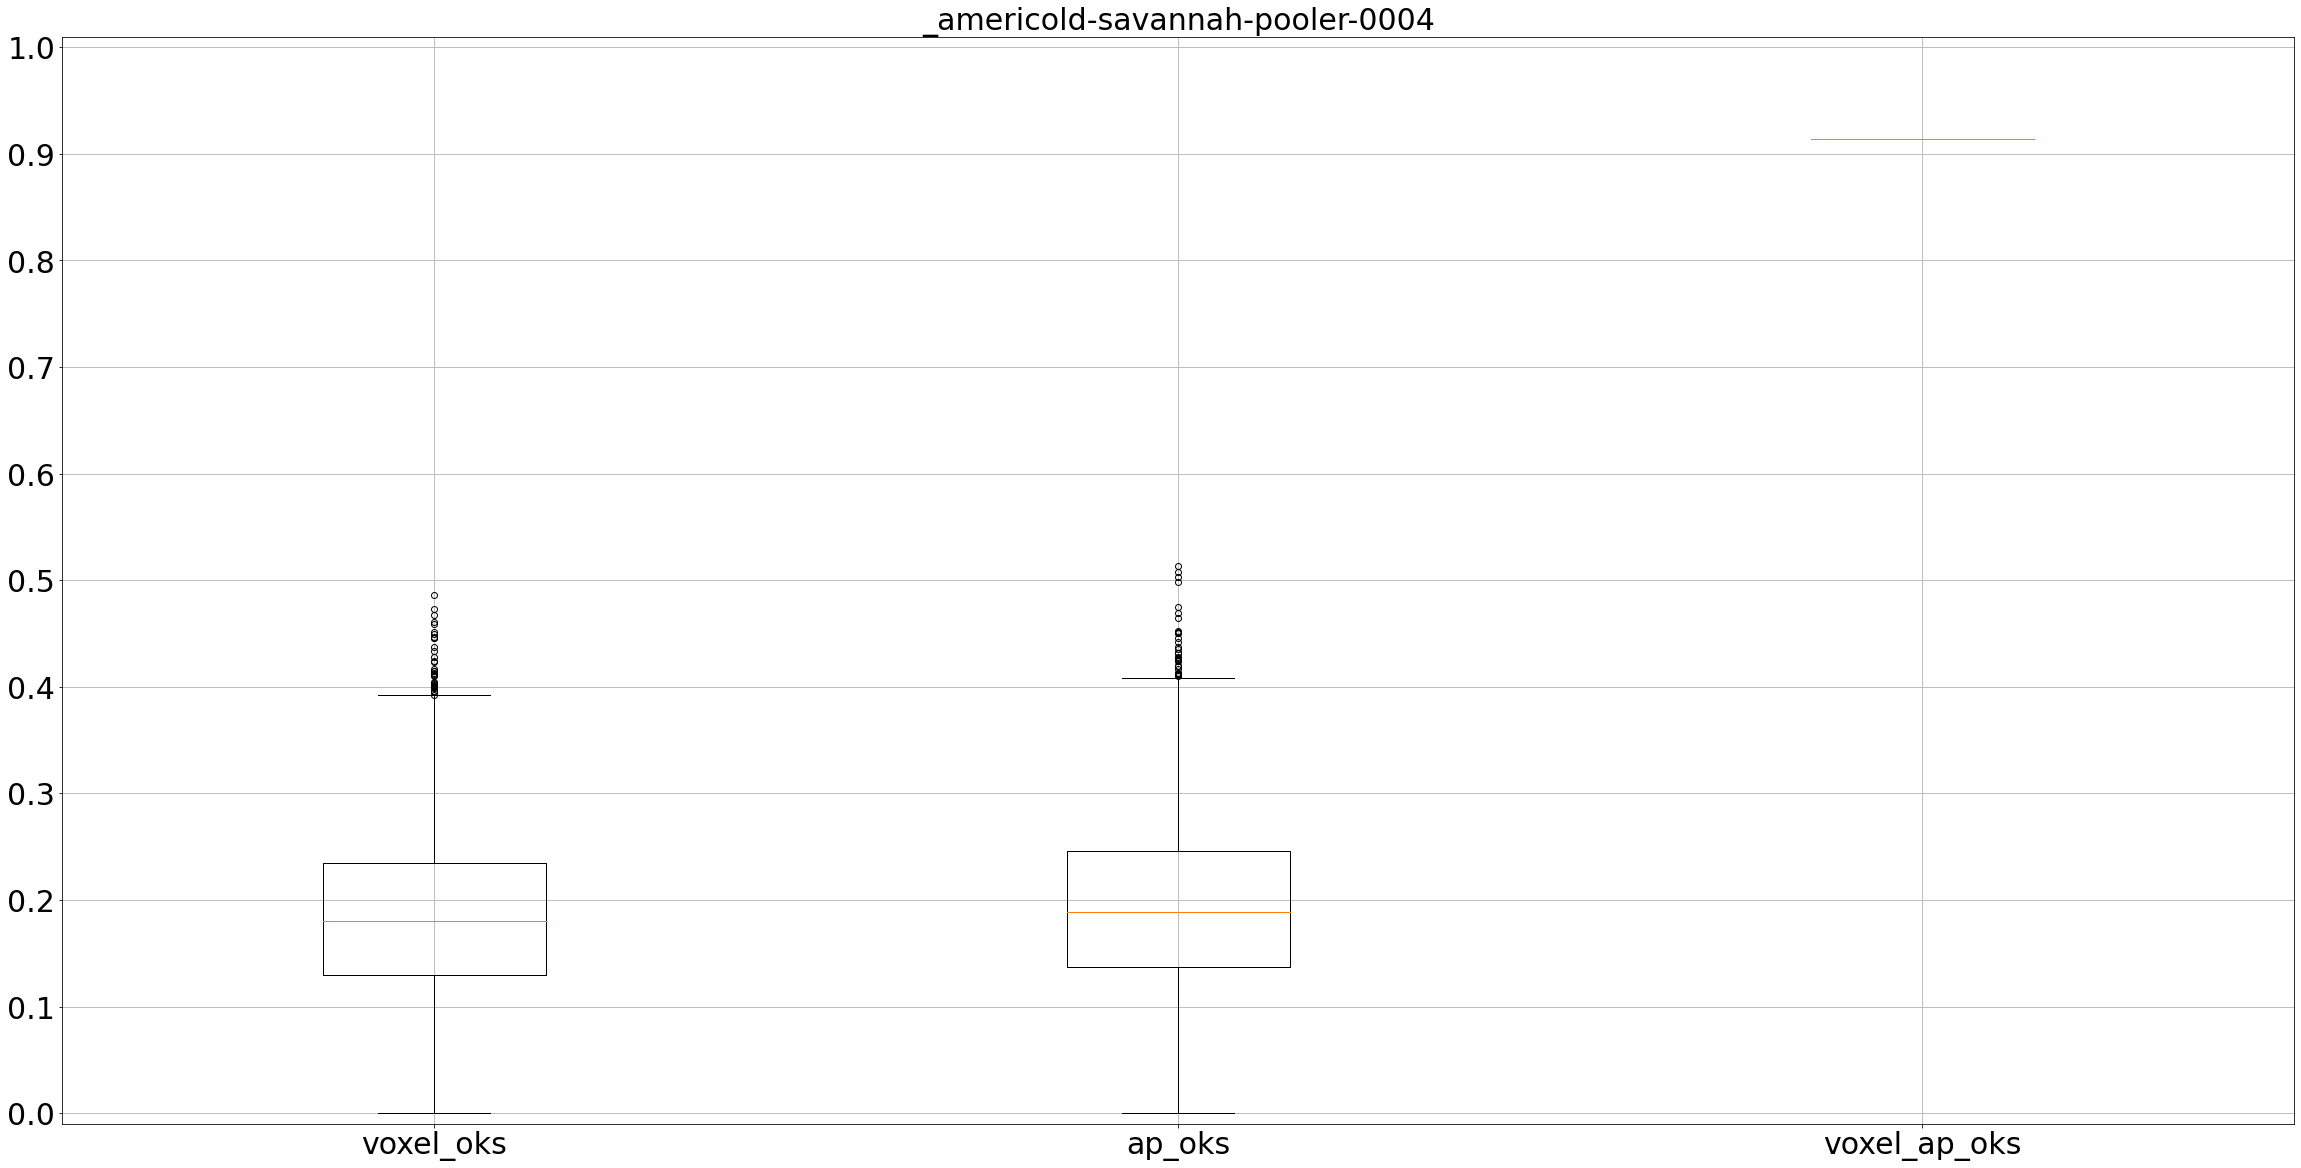

          voxel_oks       ap_oks voxel_ap_oks
count          4999         4919         4919
mean       0.184252      0.19413     0.913936
std       0.0772023    0.0788946  1.99285e-06
min    1.18184e-269  5.58477e-05     0.913931
25%         0.12914     0.137148     0.913934
50%        0.180288     0.188826     0.913936
75%        0.234394      0.24604     0.913938
max        0.486132     0.513086     0.913938


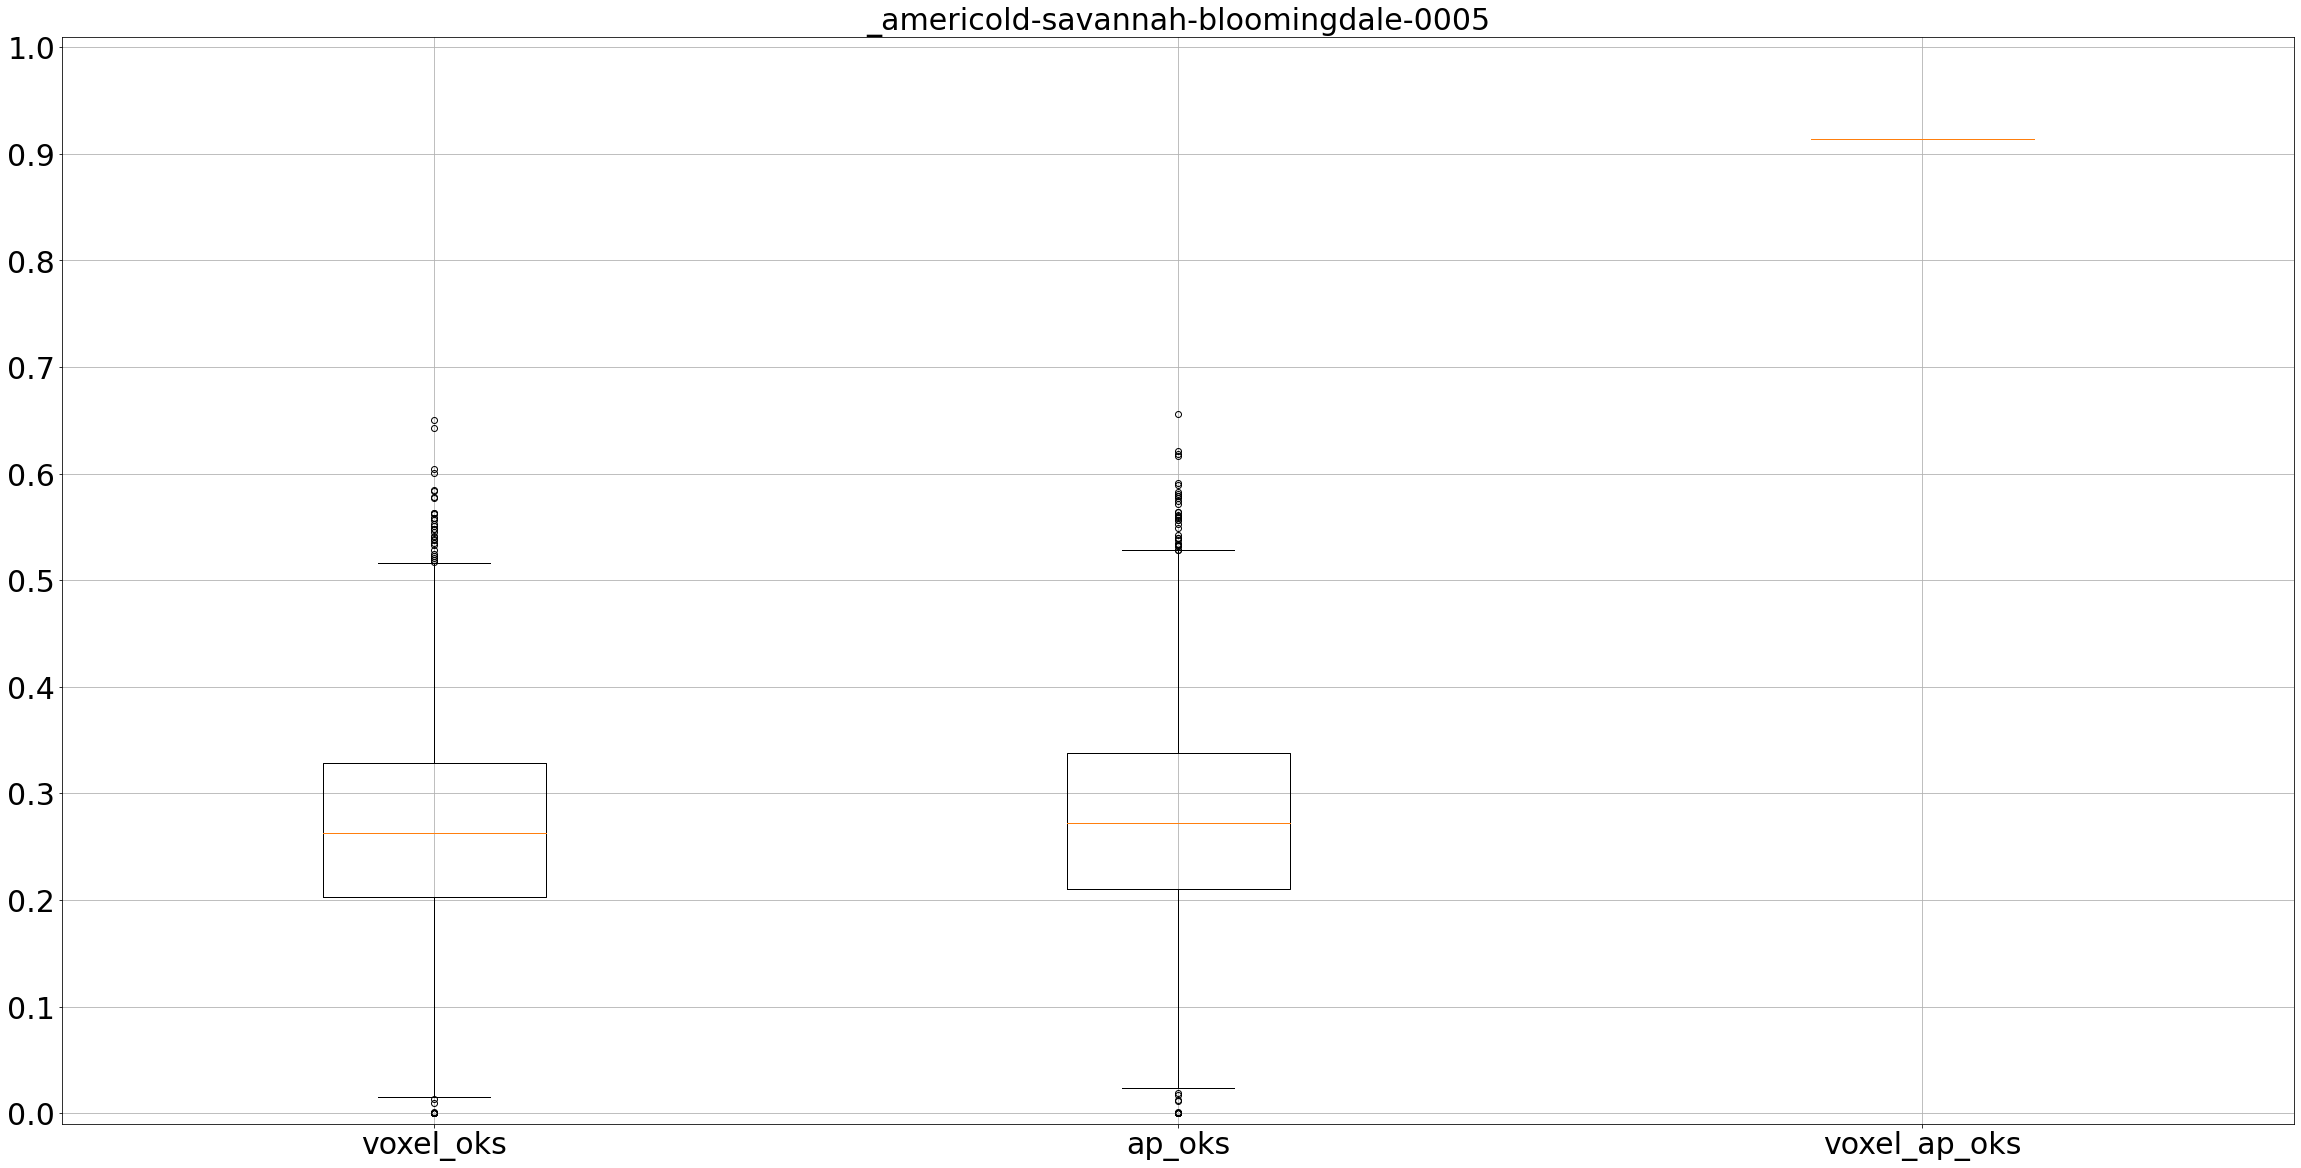

         voxel_oks       ap_oks voxel_ap_oks
count         4983         4981         4981
mean      0.267567     0.276733     0.913933
std      0.0929049    0.0949302  3.10571e-06
min    3.83439e-59  4.92538e-57      0.91393
25%       0.203055     0.210484      0.91393
50%       0.262911     0.272674     0.913934
75%        0.32846     0.337661     0.913936
max       0.650565       0.6562     0.913938


In [107]:
for dataset in datasets:
    plot_boxplot_oks(dataset)

In [86]:
data = df.to_dict()